##Install Spark Environment.





In [375]:
!apt-get update
!apt-get install openjdk-8-jdk-headless -qq > /dev/null
!wget -q https://www-us.apache.org/dist/spark/spark-2.4.5/spark-2.4.5-bin-hadoop2.7.tgz
!tar xf spark-2.4.5-bin-hadoop2.7.tgz
!pip install -q findspark

Get:1 http://security.ubuntu.com/ubuntu bionic-security InRelease [88.7 kB]
Hit:2 https://cloud.r-project.org/bin/linux/ubuntu bionic-cran35/ InRelease    
Ign:3 https://developer.download.nvidia.com/compute/cuda/repos/ubuntu1804/x86_64  InRelease
Ign:4 https://developer.download.nvidia.com/compute/machine-learning/repos/ubuntu1804/x86_64  InRelease
Hit:5 http://archive.ubuntu.com/ubuntu bionic InRelease                        
Hit:6 https://developer.download.nvidia.com/compute/cuda/repos/ubuntu1804/x86_64  Release
Hit:7 https://developer.download.nvidia.com/compute/machine-learning/repos/ubuntu1804/x86_64  Release
Hit:8 http://ppa.launchpad.net/graphics-drivers/ppa/ubuntu bionic InRelease
Get:9 http://archive.ubuntu.com/ubuntu bionic-updates InRelease [88.7 kB]      
Hit:10 http://ppa.launchpad.net/marutter/c2d4u3.5/ubuntu bionic InRelease      
Get:11 http://archive.ubuntu.com/ubuntu bionic-backports InRelease [74.6 kB]   
Get:14 http://archive.ubuntu.com/ubuntu bionic-updates/unive

In [ ]:
import os
os.environ["JAVA_HOME"] = "/usr/lib/jvm/java-8-openjdk-amd64"
os.environ["SPARK_HOME"] = "/content/spark-2.4.5-bin-hadoop2.7"

Check what files we have in our VPS and all are good at that time.

In [377]:
!ls

census-income.csv	spark-2.4.5-bin-hadoop2.7
census-income-test.csv	spark-2.4.5-bin-hadoop2.7.tgz
sample_data		spark-2.4.5-bin-hadoop2.7.tgz.1


In [378]:
import findspark
findspark.init()
from pyspark.sql import SparkSession
import seaborn as sns
spark = SparkSession.builder.master("local[*]").getOrCreate()
from pyspark import SparkContext
sc = SparkContext.getOrCreate()
sc

<SparkContext master=local[*] appName=pyspark-shell>

In [379]:
spark

Download our data from the site. Download train dataset and test dataset.

In [380]:
!wget http://archive.ics.uci.edu/ml/machine-learning-databases/census-income-mld/census-income.test.gz
!wget http://archive.ics.uci.edu/ml/machine-learning-databases/census-income-mld/census-income.data.gz

--2020-02-21 12:43:00--  http://archive.ics.uci.edu/ml/machine-learning-databases/census-income-mld/census-income.test.gz
Resolving archive.ics.uci.edu (archive.ics.uci.edu)... 128.195.10.252
Connecting to archive.ics.uci.edu (archive.ics.uci.edu)|128.195.10.252|:80... connected.
HTTP request sent, awaiting response... 200 OK
Length: 3261416 (3.1M) [application/x-httpd-php]
Saving to: ‘census-income.test.gz’

census-income.test. 100%[===================>]   3.11M  5.31MB/s    in 0.6s    

2020-02-21 12:43:01 (5.31 MB/s) - ‘census-income.test.gz’ saved [3261416/3261416]

--2020-02-21 12:43:02--  http://archive.ics.uci.edu/ml/machine-learning-databases/census-income-mld/census-income.data.gz
Resolving archive.ics.uci.edu (archive.ics.uci.edu)... 128.195.10.252
Connecting to archive.ics.uci.edu (archive.ics.uci.edu)|128.195.10.252|:80... connected.
HTTP request sent, awaiting response... 200 OK
Length: 6524338 (6.2M) [application/x-httpd-php]
Saving to: ‘census-income.data.gz’

census-inc

In [381]:
ls

census-income.csv       sample_data/
census-income.data.gz   spark-2.4.5-bin-hadoop2.7/
census-income-test.csv  spark-2.4.5-bin-hadoop2.7.tgz
census-income.test.gz   spark-2.4.5-bin-hadoop2.7.tgz.1


Unzip our data in our server and then rename files to .csv format, because data presented as comma separated files. That information have in a file description.

In [ ]:
!gunzip census-income.data.gz
!gunzip census-income.test.gz

In [383]:
ls /content/

census-income.csv   census-income-test.csv      spark-2.4.5-bin-hadoop2.7.tgz
census-income.data  sample_data/                spark-2.4.5-bin-hadoop2.7.tgz.1
census-income.test  spark-2.4.5-bin-hadoop2.7/


In [ ]:
!mv census-income.data census-income.csv
!mv census-income.test census-income-test.csv

This notebook consist several parts. ScikitLearn Part and Spark.This notebook contains a lot of models and some parameters grid search.So you can start it and it takes some time to get the proper results. I use Google Colab to create and run it.

In Part 1 we load data then transform data to Pandas dataframe and exlore data with Pandas dataframe. Then we chose ML algorithm and create model and test performance with Pandas and Scikit Learn. Here we hard explore data, choose features for the future models and make some conclusion about data, because Scikit have much more tools for that.

In Part 2 we load data and play with them as Spark dataframe. We choose numeric data only based on assumption(Part 1) that all non numeric data is equals and we need only numeric. We explore several ML algorithms and choose one with better ROC. Then we try to find most important numeric features, create models based on that important features only.

In part 3 we load data in Spark and explore ML algorithms with whole data without separating between numeric and not numeric and choose better ML algoritm, also find the difference between Part 2 - most important feature models and Part 3 model trained on all data numeric and not.


### Part1

Finally we read .csv file to the spark dataframe. As a test we just check what we have in our dataframe.

In [385]:
data_df = spark.read.csv('/content/census-income.csv')
data_df.show(5)

+---+--------------------+---+---+--------------------+---+----------------+--------------+--------------------+--------------------+--------------------+----------+-------+----------------+----------------+--------------------+----+----+----+------------------+----------------+----------------+--------------------+--------------------+--------+-----------+------------+------------+--------------------+----------------+----+--------------------+--------------+--------------+--------------+--------------------+----+----------------+----+----+----+---------+
|_c0|                 _c1|_c2|_c3|                 _c4|_c5|             _c6|           _c7|                 _c8|                 _c9|                _c10|      _c11|   _c12|            _c13|            _c14|                _c15|_c16|_c17|_c18|              _c19|            _c20|            _c21|                _c22|                _c23|    _c24|       _c25|        _c26|        _c27|                _c28|            _c29|_c30|         

In [ ]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import train_test_split

Print our Schema of our dataframe and see that all data presented as a string. We need change numeric data type to Integer and Float.

In [387]:

data_df.printSchema()

root
 |-- _c0: string (nullable = true)
 |-- _c1: string (nullable = true)
 |-- _c2: string (nullable = true)
 |-- _c3: string (nullable = true)
 |-- _c4: string (nullable = true)
 |-- _c5: string (nullable = true)
 |-- _c6: string (nullable = true)
 |-- _c7: string (nullable = true)
 |-- _c8: string (nullable = true)
 |-- _c9: string (nullable = true)
 |-- _c10: string (nullable = true)
 |-- _c11: string (nullable = true)
 |-- _c12: string (nullable = true)
 |-- _c13: string (nullable = true)
 |-- _c14: string (nullable = true)
 |-- _c15: string (nullable = true)
 |-- _c16: string (nullable = true)
 |-- _c17: string (nullable = true)
 |-- _c18: string (nullable = true)
 |-- _c19: string (nullable = true)
 |-- _c20: string (nullable = true)
 |-- _c21: string (nullable = true)
 |-- _c22: string (nullable = true)
 |-- _c23: string (nullable = true)
 |-- _c24: string (nullable = true)
 |-- _c25: string (nullable = true)
 |-- _c26: string (nullable = true)
 |-- _c27: string (nullable = tru

In [ ]:
#Dataframe Rows
#data_df.shape()

In pur Spark dataframe change '?' to Numpy NaN symbol.

In [ ]:
#data_df_T = data_df.replace(' ?',np.nan)

Convert our Spark dataframe to Pandas dataframe and work with Pandas dataframe and explore that data.First one find how many rows and columns we have, just print shape of our dataframe. First value it is a how many rows we have, second how many columns.

In [390]:
pandas_train_df = data_df.toPandas()
print(pandas_train_df.shape)

(199523, 42)


We add boolaen feature does the person have highincome or not and add this feature to our dataframe.

In [ ]:
pandas_train_df['HighIncome'] = np.where(pandas_train_df['_c41'] == ' - 50000.',False,True)

In [392]:
pandas_train_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 199523 entries, 0 to 199522
Data columns (total 43 columns):
_c0           199523 non-null object
_c1           199523 non-null object
_c2           199523 non-null object
_c3           199523 non-null object
_c4           199523 non-null object
_c5           199523 non-null object
_c6           199523 non-null object
_c7           199523 non-null object
_c8           199523 non-null object
_c9           199523 non-null object
_c10          199523 non-null object
_c11          199523 non-null object
_c12          199523 non-null object
_c13          199523 non-null object
_c14          199523 non-null object
_c15          199523 non-null object
_c16          199523 non-null object
_c17          199523 non-null object
_c18          199523 non-null object
_c19          199523 non-null object
_c20          199523 non-null object
_c21          199523 non-null object
_c22          199523 non-null object
_c23          199523 non-null object
_

Choose numeric column we have in our dataframe. Create array of columns.

In [ ]:
numeric_features = ['_c0','_c2','_c3','_c5','_c16','_c17','_c18','_c24','_c30','_c36','_c38','_c39','_c40']
#pd.to_numeric(s, downcast='integer')
#c24 float.

Change '?' symbols to NaN values in our dataframe.We deal with NaN later.

In [ ]:
pandas_train_df = pandas_train_df.replace(' ?',np.nan)

Check our dataset how many NaN we have in each columns.

In [395]:
pandas_train_df.isna().sum()

_c0               0
_c1               0
_c2               0
_c3               0
_c4               0
_c5               0
_c6               0
_c7               0
_c8               0
_c9               0
_c10              0
_c11              0
_c12              0
_c13              0
_c14              0
_c15              0
_c16              0
_c17              0
_c18              0
_c19              0
_c20              0
_c21            708
_c22              0
_c23              0
_c24              0
_c25          99696
_c26          99696
_c27          99696
_c28              0
_c29          99696
_c30              0
_c31              0
_c32           6713
_c33           6119
_c34           3393
_c35              0
_c36              0
_c37              0
_c38              0
_c39              0
_c40              0
_c41              0
HighIncome        0
dtype: int64

Change our numeric column to Integer type except column _24, which we change to Float type, then check it by call .info() method.

In [ ]:
for elem in numeric_features:
  if elem != '_c24':
    pandas_train_df[elem] = pandas_train_df[elem].astype(int)
  else:
    pandas_train_df[elem] = pandas_train_df[elem].astype(float)

In [397]:
pandas_train_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 199523 entries, 0 to 199522
Data columns (total 43 columns):
_c0           199523 non-null int64
_c1           199523 non-null object
_c2           199523 non-null int64
_c3           199523 non-null int64
_c4           199523 non-null object
_c5           199523 non-null int64
_c6           199523 non-null object
_c7           199523 non-null object
_c8           199523 non-null object
_c9           199523 non-null object
_c10          199523 non-null object
_c11          199523 non-null object
_c12          199523 non-null object
_c13          199523 non-null object
_c14          199523 non-null object
_c15          199523 non-null object
_c16          199523 non-null int64
_c17          199523 non-null int64
_c18          199523 non-null int64
_c19          199523 non-null object
_c20          199523 non-null object
_c21          198815 non-null object
_c22          199523 non-null object
_c23          199523 non-null object
_c24    

Before we deal with NaN in our datframe, drop non nesessary columns. We drop 25,26,27 because this information is not relewant to us.(migration code-change in msa			MIGMTR1,
migration code-change in reg			MIGMTR3,
migration code-move within reg			MIGMTR4).Also drop columns 32,33,34 because it is country of birth information (country of birth father				PEFNTVTY,
country of birth mother				PEMNTVTY,
country of birth self				PENATVTY). Also drop column 11,13,14,15,20,21,29 because it is irrelevant information from my opinion.

In [ ]:
drop_df = pandas_train_df.drop(['_c11','_c13','_c14','_c15','_c20','_c21','_c29','_c25','_c26','_c27','_c32','_c33','_c34'],1)

Check how much NaN we have after the dropping columns.

In [399]:
drop_df.isna().sum()

_c0           0
_c1           0
_c2           0
_c3           0
_c4           0
_c5           0
_c6           0
_c7           0
_c8           0
_c9           0
_c10          0
_c12          0
_c16          0
_c17          0
_c18          0
_c19          0
_c22          0
_c23          0
_c24          0
_c28          0
_c30          0
_c31          0
_c35          0
_c36          0
_c37          0
_c38          0
_c39          0
_c40          0
_c41          0
HighIncome    0
dtype: int64

In [400]:
drop_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 199523 entries, 0 to 199522
Data columns (total 30 columns):
_c0           199523 non-null int64
_c1           199523 non-null object
_c2           199523 non-null int64
_c3           199523 non-null int64
_c4           199523 non-null object
_c5           199523 non-null int64
_c6           199523 non-null object
_c7           199523 non-null object
_c8           199523 non-null object
_c9           199523 non-null object
_c10          199523 non-null object
_c12          199523 non-null object
_c16          199523 non-null int64
_c17          199523 non-null int64
_c18          199523 non-null int64
_c19          199523 non-null object
_c22          199523 non-null object
_c23          199523 non-null object
_c24          199523 non-null float64
_c28          199523 non-null object
_c30          199523 non-null int64
_c31          199523 non-null object
_c35          199523 non-null object
_c36          199523 non-null int64
_c37     

Create distinct table and found how many unique values we have in columns. We see in column _c0 we have 91 unique values.

In [401]:
distinct_df = pd.DataFrame()
for col in pandas_train_df:
  distinct_df[col] = pd.Series(pandas_train_df[col].nunique(),index=pandas_train_df.index)  
distinct = distinct_df.iloc[0]
distinct.head(5)

_c0    91
_c1     9
_c2    52
_c3    47
_c4    17
Name: 0, dtype: int64

Describe our dataframe.It is show us information about numeric data in our dataframe.

In [402]:
drop_df.describe()

,_c0,_c2,_c3,_c5,_c16,_c17,_c18,_c24,_c30,_c36,_c38,_c39,_c40
count,199523.000000,199523.000000,199523.000000,199523.000000,199523.00000,199523.000000,199523.000000,199523.000000,199523.000000,199523.000000,199523.000000,199523.000000,199523.000000
mean,34.494199,15.352320,11.306556,55.426908,434.71899,37.313788,197.529533,1740.380269,1.956180,0.175438,1.514833,23.174897,94.499672
std,22.310895,18.067129,14.454204,274.896454,4697.53128,271.896428,1984.163658,993.768156,2.365126,0.553694,0.851473,24.411488,0.500001
min,0.000000,0.000000,0.000000,0.000000,0.00000,0.000000,0.000000,37.870000,0.000000,0.000000,0.000000,0.000000,94.000000
25%,15.000000,0.000000,0.000000,0.000000,0.00000,0.000000,0.000000,1061.615000,0.000000,0.000000,2.000000,0.000000,94.000000
50%,33.000000,0.000000,0.000000,0.000000,0.00000,0.000000,0.000000,1618.310000,1.000000,0.000000,2.000000,8.000000,94.000000
75%,50.000000,33.000000,26.000000,0.000000,0.00000,0.000000,0.000000,2188.610000,4.000000,0.000000,2.000000,52.000000,95.000000
max,90.000000,51.000000,46.000000,9999.000000,99999.00000,4608.000000,99999.000000,18656.300000,6.000000,2.000000,2.000000,52.000000,95.000000


In [403]:
drop_df.head(2)

,_c0,_c1,_c2,_c3,_c4,_c5,_c6,_c7,_c8,_c9,_c10,_c12,_c16,_c17,_c18,_c19,_c22,_c23,_c24,_c28,_c30,_c31,_c35,_c36,_c37,_c38,_c39,_c40,_c41,HighIncome
0,73,Not in universe,0,0,High school graduate,0,Not in universe,Widowed,Not in universe or children,Not in universe,White,Female,0,0,0,Nonfiler,Other Rel 18+ ever marr not in subfamily,Other relative of householder,1700.09,Not in universe under 1 year old,0,Not in universe,Native- Born in the United States,0,Not in universe,2,0,95,- 50000.,False
1,58,Self-employed-not incorporated,4,34,Some college but no degree,0,Not in universe,Divorced,Construction,Precision production craft & repair,White,Male,0,0,0,Head of household,Householder,Householder,1053.55,No,1,Not in universe,Native- Born in the United States,0,Not in universe,2,52,94,- 50000.,False


Count how many % we have a High Income persons and Average Income persons. Also print how many persons we have in both groups.

In [404]:
income_partition = drop_df['_c41'].value_counts()
print(income_partition)


rich_fraction = income_partition[1]/float(income_partition[0])
print("From 1 reach person, is {} awerage persons.".format(1//float(rich_fraction)))
print("Reach people: {}".format(income_partition[1]))
print("Awerage people: {}".format(income_partition[0]))

 - 50000.    187141
 50000+.      12382
Name: _c41, dtype: int64
From 1 reach person, is 15.0 awerage persons.
Reach people: 12382
Awerage people: 187141


We have unbalanced dataset!Data is skewed toward one class. Then we split our dataset to features and target. Target will be boolean column HighIncome, other will be our features.

In [ ]:
X = drop_df.drop('HighIncome',1)
y = drop_df['HighIncome']

We split our X,y to the train and test set. We split our data before the finding important future. We will find our features on the training set, it prevent data test-trai leakage and spurious correlation.


In [ ]:
X_train,X_test,y_train,y_test = train_test_split(X,y,test_size=0.2, random_state=77)
X_train_copy = X_train
X_test_copy = X_test

Then we create a histograms of our numeric features and see the data distributions.

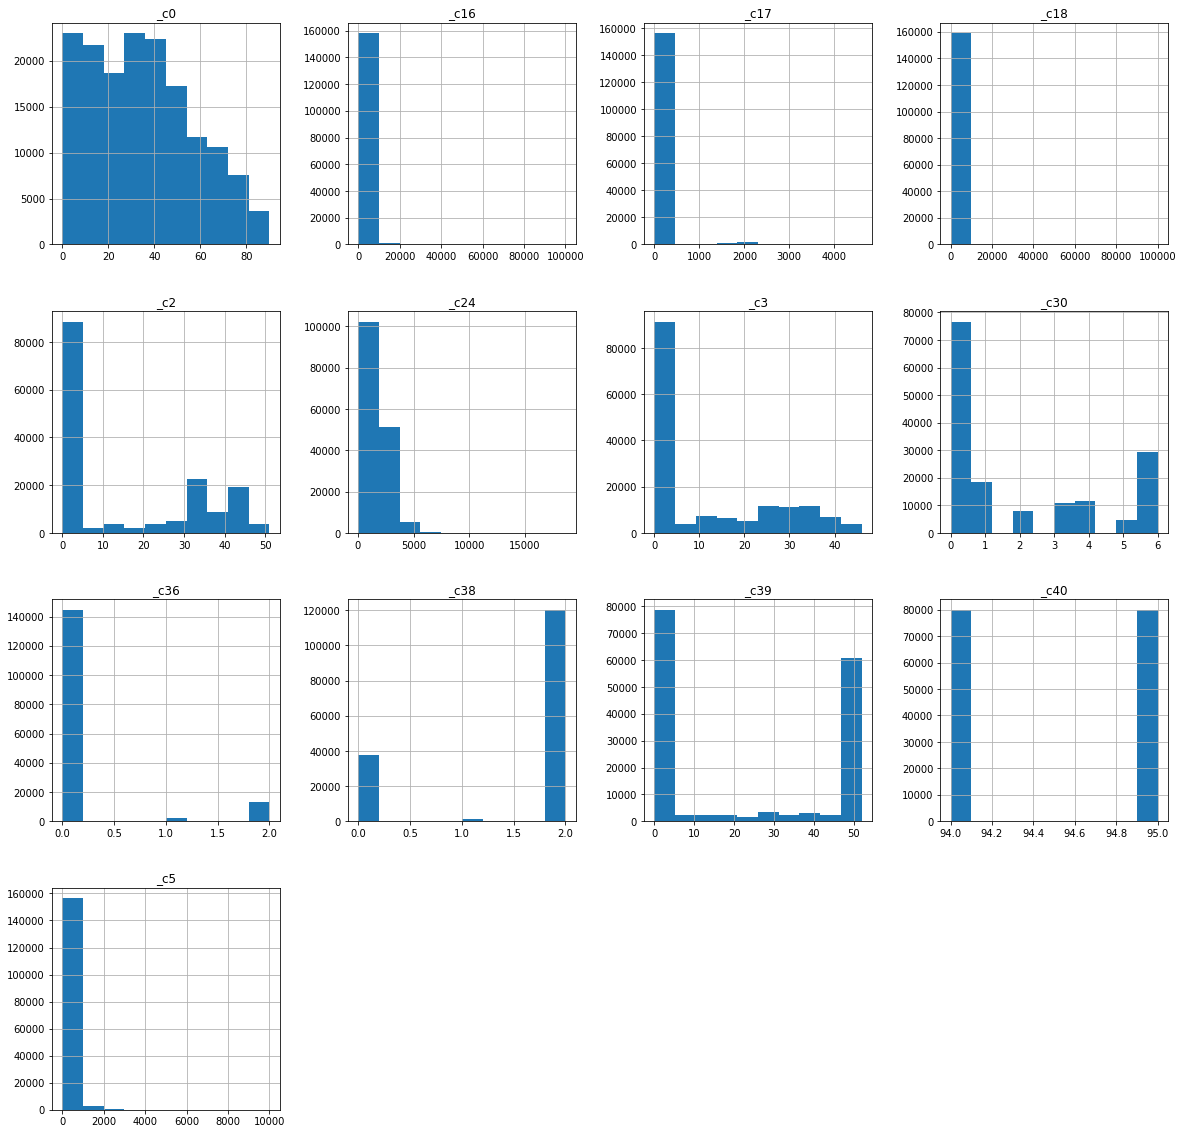

In [407]:
X_train.hist(figsize=(20,20))
plt.show()

For our numbered features create correlation matrix and try to find correlated features to drop them later. First create matrix of correlations with coefficients and then visalise it in a corellation matrix with printed coefficients.

In [408]:
data_corr = X_train.corr()
data_corr.head(5)

,_c0,_c2,_c3,_c5,_c16,_c17,_c18,_c24,_c30,_c36,_c38,_c39,_c40
_c0,1.000000,0.159435,0.118770,0.036969,0.055048,0.062320,0.105648,-0.002290,0.141473,-0.002956,0.675295,0.207579,0.005643
_c2,0.159435,1.000000,0.564285,0.164219,0.064117,0.072358,0.013263,0.028249,0.641203,0.253494,0.476783,0.754589,0.004306
_c3,0.118770,0.564285,1.000000,0.193614,-0.000417,0.043689,-0.027335,0.027616,0.516354,0.228711,0.439097,0.656024,-0.003015
_c5,0.036969,0.164219,0.193614,1.000000,-0.000647,0.011742,-0.006990,0.012146,0.191331,0.053900,0.112668,0.194779,0.004359
_c16,0.055048,0.064117,-0.000417,-0.000647,1.000000,-0.012790,0.139666,0.001568,0.058117,0.013747,0.051994,0.082059,0.005860


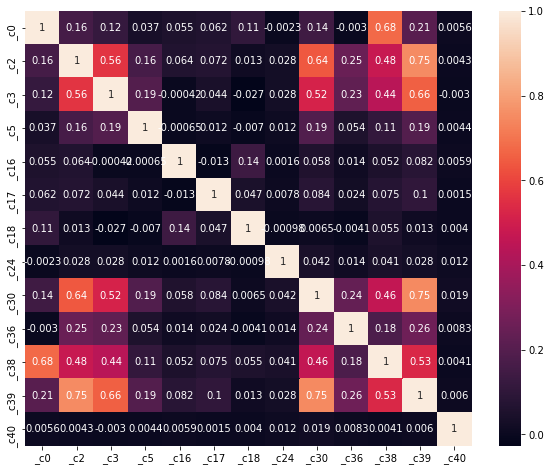

In [409]:
fig, ax = plt.subplots(figsize = (10, 8))

sns.heatmap(data_corr, annot = True)

Light colors show us corelated features between each other. In a diagnal we see 1 - feature corelated with self. So axxording our matrix we do not have correlated numeric features in our dataset. Then we print dencity distribution of our data.

In [410]:
plot_df = X_train[['_c0','_c2','_c3','_c5','_c16','_c17','_c18','_c24','_c30','_c36','_c38','_c39','_c40']]
plot_label = ['_c0','_c2','_c3','_c5','_c16','_c17','_c18','_c24','_c30','_c36','_c38','_c39','_c40']
plot_df.head(2)

,_c0,_c2,_c3,_c5,_c16,_c17,_c18,_c24,_c30,_c36,_c38,_c39,_c40
111528,40,43,12,1500,0,0,0,2257.98,4,0,2,28,95
182461,34,4,34,0,0,0,0,1765.64,1,0,2,44,95


No handles with labels found to put in legend.
No handles with labels found to put in legend.
No handles with labels found to put in legend.
No handles with labels found to put in legend.
No handles with labels found to put in legend.
No handles with labels found to put in legend.
No handles with labels found to put in legend.
No handles with labels found to put in legend.
No handles with labels found to put in legend.
No handles with labels found to put in legend.
No handles with labels found to put in legend.
No handles with labels found to put in legend.
No handles with labels found to put in legend.
No handles with labels found to put in legend.


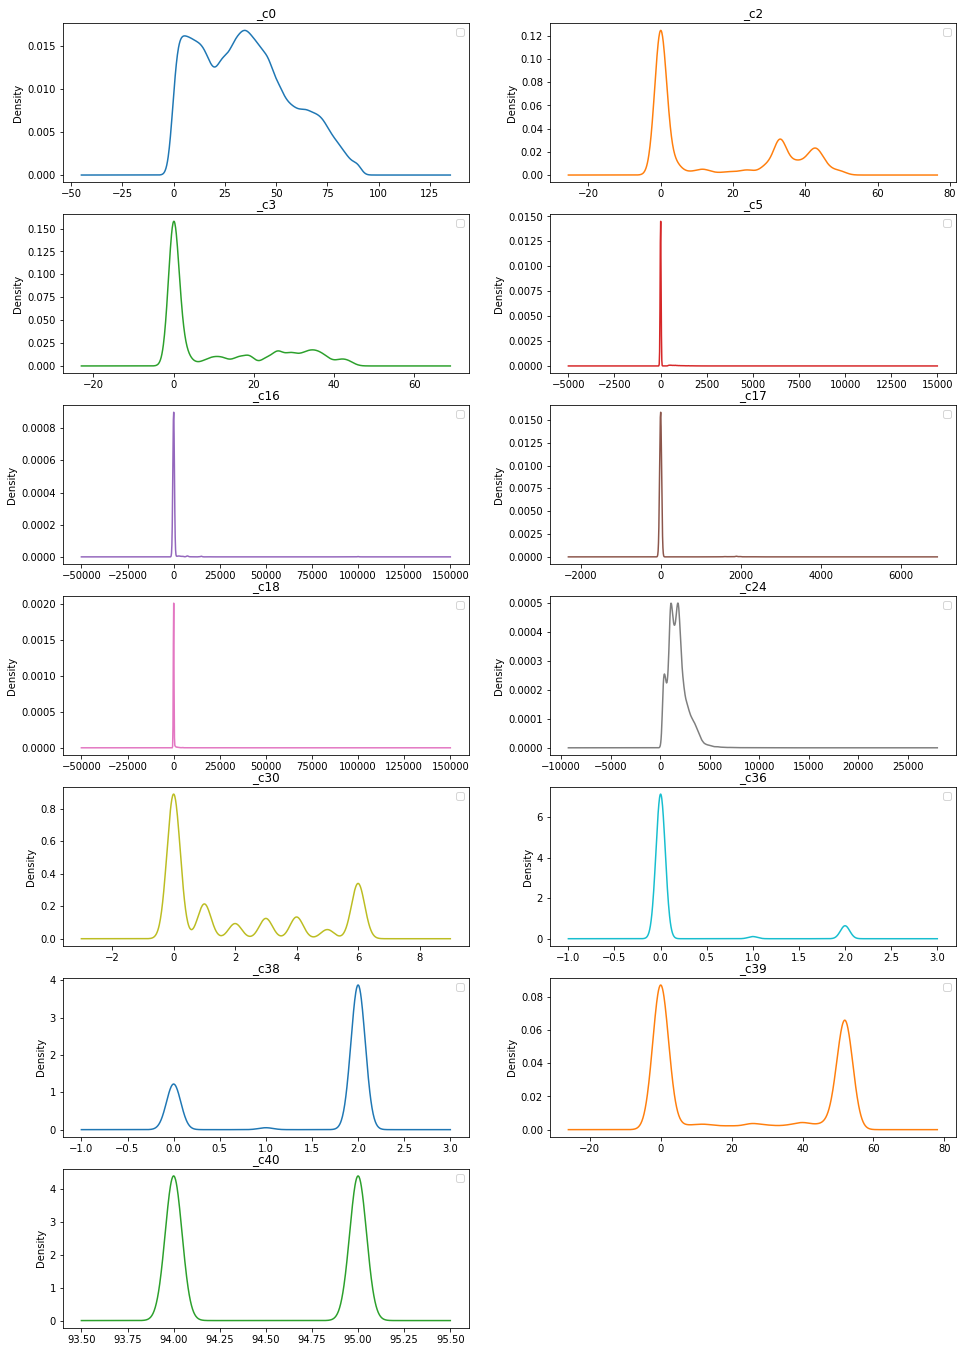

In [411]:
plot_df.plot(kind='density', 
                   subplots=True, 
                   layout=(7, 2), 
                   sharex=False, 
                   figsize=(16, 24),
                   title =  ['_c0','_c2','_c3','_c5','_c16','_c17','_c18','_c24','_c30','_c36','_c38','_c39','_c40']
                   )
plt.legend()
plt.show()

We saw that most of our numeric data does not have Gaussian distribution - we need use data normalisation for the better result.Find the meaningful features. We normalise features by minmax scaler, drow a boxplot and choose feaatures with bigger variance and prop with small.

In [ ]:
from sklearn.preprocessing import minmax_scale
num_feature_df = X_train[['_c0','_c2','_c3','_c5','_c16','_c17','_c18','_c24','_c30','_c36','_c38','_c39','_c40']]
df_scaled = pd.DataFrame(minmax_scale(num_feature_df, feature_range=(0, 10)), columns=num_feature_df.columns)


In [413]:
df_scaled.var()

_c0      6.138925
_c2     12.552004
_c3      9.879734
_c5      0.077927
_c16     0.216767
_c17     0.342966
_c18     0.038780
_c24     0.284358
_c30    15.566101
_c36     7.684654
_c38    18.111349
_c39    22.042776
_c40    25.000156
dtype: float64

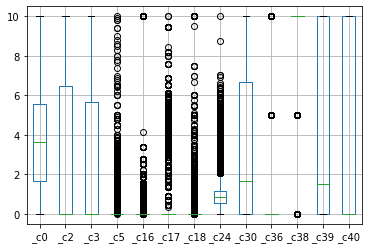

In [414]:
df_scaled.boxplot()

We see a boxplot, but data is not with Gaussian distribution.We will do the StandartScaling and again draw a box plot.

In [ ]:
from sklearn.preprocessing import StandardScaler
stand_scaler = StandardScaler()
stand_scaler = stand_scaler.fit(num_feature_df)
standartised_features = stand_scaler.transform(num_feature_df)

In [416]:
standartised_features_df = pd.DataFrame(standartised_features,columns=num_feature_df.columns)
standartised_features_df.describe()

,_c0,_c2,_c3,_c5,_c16,_c17,_c18,_c24,_c30,_c36,_c38,_c39,_c40
count,1.596180e+05,1.596180e+05,1.596180e+05,1.596180e+05,1.596180e+05,1.596180e+05,1.596180e+05,1.596180e+05,1.596180e+05,1.596180e+05,1.596180e+05,1.596180e+05,1.596180e+05
mean,1.621244e-16,6.447790e-16,6.169292e-16,1.016768e-14,-1.325187e-15,1.302376e-15,-1.713686e-15,-1.896042e-16,2.544976e-15,-2.153858e-15,-2.298405e-15,-1.650230e-15,8.253174e-15
std,1.000003e+00,1.000003e+00,1.000003e+00,1.000003e+00,1.000003e+00,1.000003e+00,1.000003e+00,1.000003e+00,1.000003e+00,1.000003e+00,1.000003e+00,1.000003e+00,1.000003e+00
min,-1.547379e+00,-8.512699e-01,-7.838828e-01,-2.011446e-01,-9.316459e-02,-1.372885e-01,-1.003491e-01,-1.715920e+00,-8.285308e-01,-3.173710e-01,-1.780297e+00,-9.505426e-01,-9.998747e-01
25%,-8.747058e-01,-8.512699e-01,-7.838828e-01,-2.011446e-01,-9.316459e-02,-1.372885e-01,-1.003491e-01,-6.830733e-01,-8.285308e-01,-3.173710e-01,5.694761e-01,-9.505426e-01,-9.998747e-01
50%,-6.749824e-02,-8.512699e-01,-7.838828e-01,-2.011446e-01,-9.316459e-02,-1.372885e-01,-1.003491e-01,-1.225639e-01,-4.060955e-01,-3.173710e-01,5.694761e-01,-6.228589e-01,-9.998747e-01
75%,6.948644e-01,9.750994e-01,1.014343e+00,-2.011446e-01,-9.316459e-02,-1.372885e-01,-1.003491e-01,4.514600e-01,8.612103e-01,-3.173710e-01,5.694761e-01,1.179402e+00,1.000125e+00
max,2.488659e+00,1.971301e+00,2.397594e+00,3.562149e+01,2.138539e+01,1.693831e+01,5.067997e+01,1.703699e+01,1.706081e+00,3.289987e+00,5.694761e-01,1.179402e+00,1.000125e+00


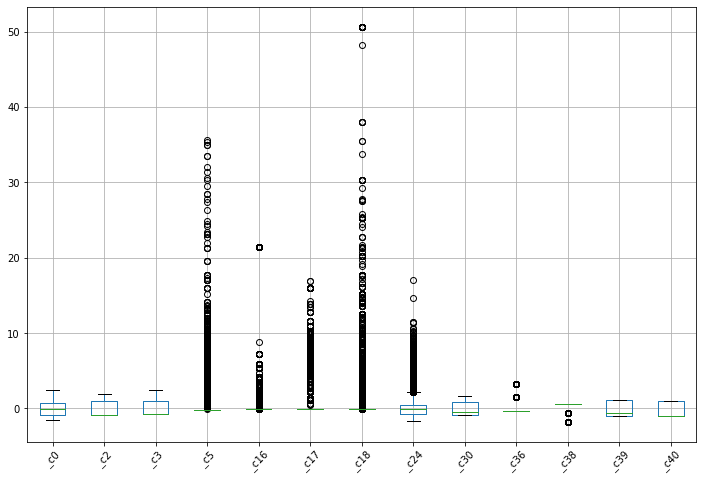

In [417]:
standartised_features_df.boxplot(figsize=(12,8),rot=45)
plt.show()

According variance of the features and boxplot of the standart normalised features we chose feature with variance bigger then 1, and boxplots without many outlier values. According the boxplot 36 and 38 looks not so good, but we choose them anyway. Data _c5,_c16,_c17,_c18,_c24 have too many outliers.

In [ ]:
choosed_num_feat = ['_c0','_c2','_c3','_c30','_c36','_c38','_c39','_c40']

In [ ]:
nonNum_feat = ['_c0','_c2','_c3','_c30','_c36','_c38','_c39','_c40']

Choose Mutual Information Feature Selection to choose our non numeric features.

In [ ]:
from sklearn.feature_selection import SelectKBest
from sklearn.preprocessing import LabelEncoder
from sklearn.preprocessing import OrdinalEncoder
from sklearn.feature_selection import mutual_info_classif

# feature selection
def select_features_mutual(X_train, y_train, X_test):
	fs = SelectKBest(score_func=mutual_info_classif, k='all')
	fs.fit(X_train, y_train)
	X_train_fs = fs.transform(X_train)
	X_test_fs = fs.transform(X_test)
	return X_train_fs, X_test_fs, fs

def prepare_inputs(X_train, X_test):
	oe = OrdinalEncoder()
	oe.fit(X_train)
	X_train_enc = oe.transform(X_train)
	X_test_enc = oe.transform(X_test)
	return X_train_enc, X_test_enc
 
# prepare target
def prepare_targets(y_train, y_test):
	le = LabelEncoder()
	le.fit(y_train)
	y_train_enc = le.transform(y_train)
	y_test_enc = le.transform(y_test)
	return y_train_enc, y_test_enc

Print our features and the score - better features with better score.

In [ ]:
# we have cut feature c41 because it is our target feature with corr coeff 1.
nonNum_feat = ['_c1','_c4','_c6','_c7','_c8','_c9','_c10','_c12','_c19','_c22','_c23','_c28',
               '_c31','_c35','_c37']

In [ ]:
X_train_nn = X_train[nonNum_feat]
X_test_nn = X_test[nonNum_feat]

In [ ]:
X_train_enc,X_test_enc = prepare_inputs(X_train_nn,X_test_nn)

In [ ]:
y_train_enc, y_test_enc = prepare_targets(y_train, y_test)

In [ ]:
X_train_fs,X_test_fs,fs = select_features_mutual(X_train_enc,y_train_enc,X_test_enc)

In [426]:
for i in range(len(fs.scores_)):
	print('Feature %d: %f' % (i, fs.scores_[i]))

Feature 0: 0.044406
Feature 1: 0.061897
Feature 2: 0.035054
Feature 3: 0.035723
Feature 4: 0.045287
Feature 5: 0.060899
Feature 6: 0.028595
Feature 7: 0.019395
Feature 8: 0.044738
Feature 9: 0.041018
Feature 10: 0.040800
Feature 11: 0.015146
Feature 12: 0.043282
Feature 13: 0.031681
Feature 14: 0.034647


According to the Mutual information score it is not clearly possible to see what feture is more important because score is more or less similar.

In [ ]:
def select_features_chi(X_train, y_train, X_test):
	fs = SelectKBest(score_func=chi2, k=4)
	fs.fit(X_train, y_train)
	X_train_fs = fs.transform(X_train)
	X_test_fs = fs.transform(X_test)
	return X_train_fs, X_test_fs

In [ ]:
X_train_fs,X_test_fs,fs = select_features_mutual(X_train_enc,y_train_enc,X_test_enc)

In [429]:
for i in range(len(fs.scores_)):
	print('Feature %d: %f' % (i, fs.scores_[i]))

Feature 0: 0.045302
Feature 1: 0.062311
Feature 2: 0.034721
Feature 3: 0.034142
Feature 4: 0.045965
Feature 5: 0.062168
Feature 6: 0.028760
Feature 7: 0.020696
Feature 8: 0.045110
Feature 9: 0.040876
Feature 10: 0.038913
Feature 11: 0.016304
Feature 12: 0.044372
Feature 13: 0.030595
Feature 14: 0.034213


We have probably same result with chi stats. Anyway we choose feature 0,1,4,5,8. It is features _c1,_c4,_c8,_c9,_c19

In [ ]:
final_features = ['_c0','_c2','_c3','_c4','_c9','_c30','_c36','_c38','_c39','_c40']

In [ ]:
#just made a copy
X_train_copy = X_train
X_test_copy = X_test

In [ ]:
X_train = X_train[final_features]
X_test = X_test[final_features]

In [433]:
X_train.head(3)

,_c0,_c2,_c3,_c4,_c9,_c30,_c36,_c38,_c39,_c40
111528,40,43,12,Some college but no degree,Professional specialty,4,0,2,28,95
182461,34,4,34,Some college but no degree,Precision production craft & repair,1,0,2,44,95
35925,6,0,0,Children,Not in universe,0,0,0,0,94


In [434]:
X_train['_c4'].value_counts()

 High school graduate                      38813
 Children                                  37897
 Some college but no degree                22210
 Bachelors degree(BA AB BS)                16000
 7th and 8th grade                          6407
 10th grade                                 5981
 11th grade                                 5514
 Masters degree(MA MS MEng MEd MSW MBA)     5234
 9th grade                                  4928
 Associates degree-occup /vocational        4298
 Associates degree-academic program         3528
 5th or 6th grade                           2650
 12th grade no diploma                      1675
 1st 2nd 3rd or 4th grade                   1418
 Prof school degree (MD DDS DVM LLB JD)     1413
 Doctorate degree(PhD EdD)                   990
 Less than 1st grade                         662
Name: _c4, dtype: int64

In [435]:
X_train['_c9'].value_counts()

 Not in universe                          80405
 Adm support including clerical           11834
 Professional specialty                   11187
 Executive admin and managerial            9944
 Other service                             9770
 Sales                                     9464
 Precision production craft & repair       8442
 Machine operators assmblrs & inspctrs     5080
 Handlers equip cleaners etc               3341
 Transportation and material moving        3220
 Farming forestry and fishing              2496
 Technicians and related support           2449
 Protective services                       1329
 Private household services                 634
 Armed Forces                                23
Name: _c9, dtype: int64

In [436]:
ord_enc = OrdinalEncoder()
small_4 = X_train[['_c4','_c9']]
ord_enc.fit(small_4)
print(ord_enc.transform(small_4))

[[16. 10.]
 [16.  8.]
 [10.  6.]
 ...
 [ 3.  6.]
 [12. 12.]
 [16.  0.]]


In [ ]:
#One hot encoding
from sklearn.preprocessing import OneHotEncoder

In [ ]:
one_hot_encoder_4 = OneHotEncoder()
one_hot_encoder_9 = OneHotEncoder()

In [ ]:
c4_transformed = one_hot_encoder_4.fit_transform(X_train[['_c4']])
c9_transformed = one_hot_encoder_9.fit_transform(X_train[['_c9']])

In [440]:
c4_transformed.toarray()

array([[0., 0., 0., ..., 0., 0., 1.],
       [0., 0., 0., ..., 0., 0., 1.],
       [0., 0., 0., ..., 0., 0., 0.],
       ...,
       [0., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 1.]])

In [441]:
one_hot_encoder_4.categories_

[array([' 10th grade', ' 11th grade', ' 12th grade no diploma',
        ' 1st 2nd 3rd or 4th grade', ' 5th or 6th grade',
        ' 7th and 8th grade', ' 9th grade',
        ' Associates degree-academic program',
        ' Associates degree-occup /vocational',
        ' Bachelors degree(BA AB BS)', ' Children',
        ' Doctorate degree(PhD EdD)', ' High school graduate',
        ' Less than 1st grade', ' Masters degree(MA MS MEng MEd MSW MBA)',
        ' Prof school degree (MD DDS DVM LLB JD)',
        ' Some college but no degree'], dtype=object)]

In [442]:
one_hot_encoder_9.categories_

[array([' Adm support including clerical', ' Armed Forces',
        ' Executive admin and managerial', ' Farming forestry and fishing',
        ' Handlers equip cleaners etc ',
        ' Machine operators assmblrs & inspctrs', ' Not in universe',
        ' Other service', ' Precision production craft & repair',
        ' Private household services', ' Professional specialty',
        ' Protective services', ' Sales',
        ' Technicians and related support',
        ' Transportation and material moving'], dtype=object)]

In [ ]:
c4_trans_df = pd.DataFrame(c4_transformed.toarray(),columns=one_hot_encoder_4.categories_,dtype=np.int)
c9_trans_df = pd.DataFrame(c9_transformed.toarray(),columns=one_hot_encoder_9.categories_,dtype=np.int)

In [444]:
c4_trans_df.head(5)

,10th grade,11th grade,12th grade no diploma,1st 2nd 3rd or 4th grade,5th or 6th grade,7th and 8th grade,9th grade,Associates degree-academic program,Associates degree-occup /vocational,Bachelors degree(BA AB BS),Children,Doctorate degree(PhD EdD),High school graduate,Less than 1st grade,Masters degree(MA MS MEng MEd MSW MBA),Prof school degree (MD DDS DVM LLB JD),Some college but no degree
0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1
1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1
2,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0
3,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0
4,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0


In [445]:
c9_trans_df.head(5)

,Adm support including clerical,Armed Forces,Executive admin and managerial,Farming forestry and fishing,Handlers equip cleaners etc,Machine operators assmblrs & inspctrs,Not in universe,Other service,Precision production craft & repair,Private household services,Professional specialty,Protective services,Sales,Technicians and related support,Transportation and material moving
0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0
1,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0
2,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0
3,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0
4,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0


In [ ]:
c4_dummy_train = pd.get_dummies(X_train['_c4'])
c9_dummy_train = pd.get_dummies(X_train['_c9'])
X_train_droped = X_train.drop(['_c4','_c9'],1)

In [ ]:
X_train_final = pd.concat([c4_dummy_train,c9_dummy_train,X_train_droped],axis=1)

In [ ]:
c4_dummy_test = pd.get_dummies(X_test['_c4'])
c9_dummy_test = pd.get_dummies(X_test['_c9'])
X_test_droped = X_test.drop(['_c4','_c9'],1)

In [ ]:
X_test_final = pd.concat([c4_dummy_test,c9_dummy_test,X_test_droped],axis=1)

We have not continious target value so it is classification problem.So we try to exam the following models DecisionTree, SVM, Knearest kneighbors classifier,Logistic regression and ensemble methods. All that kind of models can solve our classification problem.

In [ ]:
from sklearn import tree
clf_tree = tree.DecisionTreeClassifier()
clf_tree = clf_tree.fit(X_train_final,y_train)

In [451]:
print("Training_score : ", clf_tree.score(X_train_final,y_train))

Training_score :  0.9917114611134082


In [452]:
print("Test_score : ", clf_tree.score(X_test_final,y_test))

Test_score :  0.9229169277032954


Not good because all are negative and becuse of the data is only 6% rich peoples, accurasy is 94% but all poor

In [453]:
from sklearn.metrics import confusion_matrix
y_test_pred = clf_tree.predict(X_test_final)
confusion_matrix(y_test, y_test_pred)

array([[35946,  1517],
       [ 1559,   883]])

In [454]:
y_train_pred = clf_tree.predict(X_train_final)
confusion_matrix(y_train, y_train_pred)

array([[149602,     76],
       [  1247,   8693]])

In [ ]:
from sklearn import metrics

In [ ]:
y_test_pred = clf_tree.predict(X_test_final)
fpr, tpr, thresholds = metrics.roc_curve(y_test, y_test_pred)

In [457]:
roc_auc = metrics.auc(fpr,tpr)
print(roc_auc)

0.6605477874396541


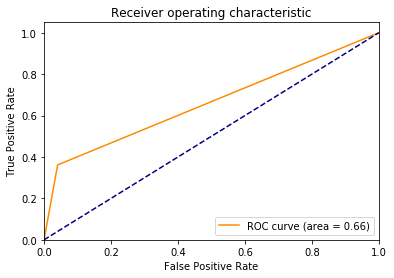

In [458]:
plt.figure()
plt.plot(fpr, tpr, color='darkorange',  label='ROC curve (area = %0.2f)' % roc_auc)
plt.plot([0, 1], [0, 1], color='navy', linestyle='--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver operating characteristic')
plt.legend(loc="lower right")
plt.show()

In [ ]:
fpr, tpr, thresholds = metrics.roc_curve(y_train, y_train_pred)


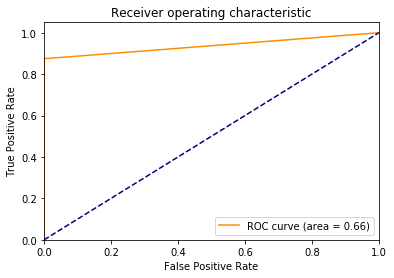

In [460]:
plt.figure()
plt.plot(fpr, tpr, color='darkorange',  label='ROC curve (area = %0.2f)' % roc_auc)
plt.plot([0, 1], [0, 1], color='navy', linestyle='--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver operating characteristic')
plt.legend(loc="lower right")
plt.show()

In [ ]:
# For training data ROC curve is close to 1 and for test it is 0.68 clearly indicate that our model overfitted.

To prevent overfitting we can do the following, train on more data. In our case we can just to change in the dividing part % on train and test. Also we can do cross validation on our training dataset. Also we can remove some features ant retrain model again.Also in a tree we can do pruning the tree branch.

Here we ranged depth of our tree to the 10, retrain models and wee the metrics.By default decision tree overfeet very easy, without prunning the branch.

In [ ]:
clf_tree = tree.DecisionTreeClassifier(max_depth=10) # here we ranged depth of our tree to the 5, retrain models and wee the metrics.

In [463]:
clf_tree = clf_tree.fit(X_train_final,y_train)
print("Training_score : ", clf_tree.score(X_train_final,y_train))

Training_score :  0.948376749489406


In [464]:
print("Test_score : ", clf_tree.score(X_test_final,y_test))

Test_score :  0.9444430522490916


In [465]:
y_test_pred = clf_tree.predict(X_test_final)
y_train_pred = clf_tree.predict(X_train_final)
confusion_matrix(y_test, y_test_pred)

array([[37051,   412],
       [ 1805,   637]])

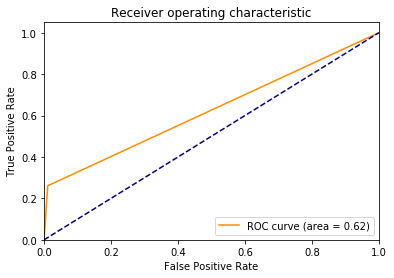

In [466]:
fpr, tpr, thresholds = metrics.roc_curve(y_test, y_test_pred)
roc_auc = metrics.auc(fpr,tpr)
plt.figure()
plt.plot(fpr, tpr, color='darkorange',  label='ROC curve (area = %0.2f)' % roc_auc)
plt.plot([0, 1], [0, 1], color='navy', linestyle='--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver operating characteristic')
plt.legend(loc="lower right")
plt.show()

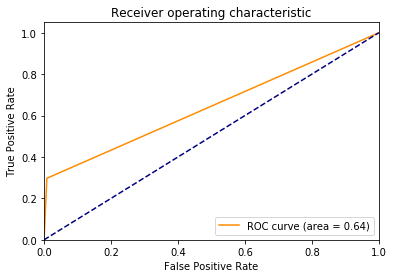

In [467]:
fpr, tpr, thresholds = metrics.roc_curve(y_train, y_train_pred)
roc_auc = metrics.auc(fpr,tpr)
plt.figure()
plt.plot(fpr, tpr, color='darkorange',  label='ROC curve (area = %0.2f)' % roc_auc)
plt.plot([0, 1], [0, 1], color='navy', linestyle='--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver operating characteristic')
plt.legend(loc="lower right")
plt.show()

Result is just a little better, model is overfitted but score of the test and train probablye the same. Next we find most important feature and cut non important.

In [468]:
clf_tree.feature_importances_

array([2.40454310e-04, 2.67306964e-04, 3.09783343e-04, 0.00000000e+00,
       0.00000000e+00, 0.00000000e+00, 9.08038510e-05, 2.38552314e-05,
       1.22315901e-03, 4.11478644e-02, 0.00000000e+00, 4.34328909e-02,
       3.35407249e-02, 0.00000000e+00, 5.13301032e-02, 5.31525616e-02,
       2.58033908e-03, 7.82678677e-04, 1.39598269e-04, 1.48982994e-03,
       2.08292341e-04, 0.00000000e+00, 2.01681864e-04, 1.55931070e-03,
       0.00000000e+00, 7.77638633e-03, 0.00000000e+00, 1.14942664e-03,
       8.10399890e-03, 3.76972263e-04, 8.24781331e-05, 1.26303728e-03,
       1.35871635e-01, 5.88419959e-02, 2.79190865e-01, 3.66626949e-02,
       4.30004952e-03, 1.15546659e-03, 2.27543726e-01, 5.96002892e-03])

We clearly see that feature number _c0,_c3,_39.Mean that numeric feature only matter in our case.


In [469]:
X_train_droped.head(5)

,_c0,_c2,_c3,_c30,_c36,_c38,_c39,_c40
111528,40,43,12,4,0,2,28,95
182461,34,4,34,1,0,2,44,95
35925,6,0,0,0,0,0,0,94
4789,78,0,0,0,0,2,0,94
67727,9,0,0,0,0,0,0,94


In [ ]:
X_train_3best = X_train_droped[['_c0','_c3','_c39']]
X_test_3best = X_test_droped[['_c0','_c3','_c39']]

In [471]:
X_train_3best

,_c0,_c3,_c39
111528,40,12,28
182461,34,34,44
35925,6,0,0
4789,78,0,0
67727,9,0,0
...,...,...,...
107813,35,36,52
190420,35,0,0
192084,76,0,0
74335,38,19,32


In [472]:
clf_tree_best = tree.DecisionTreeClassifier(max_depth=10)
clf_tree_best = clf_tree_best.fit(X_train_3best,y_train)
print("Training_score : ", clf_tree_best.score(X_train_3best,y_train))

Training_score :  0.9426129885100678


In [473]:
print("Test_score : ", clf_tree_best.score(X_test_3best,y_test))

Test_score :  0.9428392432026061


Quality resume the same so we try to leave one important feature.Let's leave only _c3.

In [474]:
clf_tree_best.feature_importances_

array([0.18302469, 0.52201385, 0.29496146])

In [475]:
y_train_pred_best = clf_tree_best.predict(X_train_3best)
confusion_matrix(y_train, y_train_pred_best)

array([[148895,    783],
       [  8377,   1563]])

In [476]:
y_test_pred_best = clf_tree_best.predict(X_test_3best)
confusion_matrix(y_test, y_test_pred_best)

array([[37239,   224],
       [ 2057,   385]])

In [ ]:
X_train_1best = X_train_droped[['_c3','_c39']]
X_test_1best = X_test_droped[['_c3','_c39']]

In [478]:
clf_tree_1best = tree.DecisionTreeClassifier(max_depth=10)
clf_tree_1best = clf_tree_1best.fit(X_train_1best,y_train)
print("Training_score : ", clf_tree_1best.score(X_train_1best,y_train))

Training_score :  0.9407522961069553


In [479]:
print("Test_score : ", clf_tree_1best.score(X_test_1best,y_test))

Test_score :  0.9426387670717955


In [480]:
y_test_pred_best = clf_tree_1best.predict(X_test_1best)
confusion_matrix(y_test, y_test_pred_best)

array([[37291,   172],
       [ 2117,   325]])

We have too many false negati Our datave during all our tests. First of all we need more people with high income in our dataset but we can not add more data with HighIncome persons.Our dataset is clearly unbalanced.

---



In [481]:
clf_tree_1best.feature_importances_
X_train_droped.head(5)

,_c0,_c2,_c3,_c30,_c36,_c38,_c39,_c40
111528,40,43,12,4,0,2,28,95
182461,34,4,34,1,0,2,44,95
35925,6,0,0,0,0,0,0,94
4789,78,0,0,0,0,2,0,94
67727,9,0,0,0,0,0,0,94


So go step back and try a new ML algoritms to improuve our solution. We tray SVM and Logistic regression models.

In [482]:
from sklearn import svm
clf_svm = svm.SVC(max_iter=70)
clf_svm = clf_svm.fit(X_train_droped,y_train)
print("Training_score : ", clf_svm.score(X_train_droped,y_train))
print("Test_score : ", clf_svm.score(X_test_droped,y_test))


/usr/local/lib/python3.6/dist-packages/sklearn/svm/_base.py:231: ConvergenceWarning: Solver terminated early (max_iter=70).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  % self.max_iter, ConvergenceWarning)


Training_score :  0.7879813053665626
Test_score :  0.7869690514973061


In [483]:
y_test_pred = clf_svm.predict(X_test_droped)
confusion_matrix(y_test, y_test_pred)


array([[29809,  7654],
       [  847,  1595]])

In [484]:
print("Accuracy test_score : ", metrics.accuracy_score(y_test_pred,y_test))

Accuracy test_score :  0.7869690514973061


In [485]:
y_train_pred = clf_svm.predict(X_train_droped)
confusion_matrix(y_train, y_train_pred)

array([[118927,  30751],
       [  3091,   6849]])

In [486]:
print("Accuracy train_score : ", metrics.accuracy_score(y_train_pred,y_train))

Accuracy train_score :  0.7879813053665626


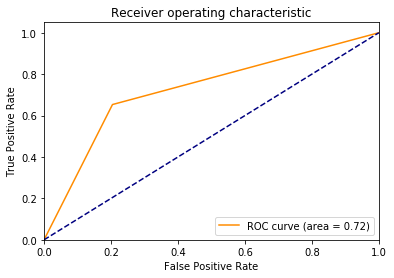

In [487]:
fpr, tpr, thresholds = metrics.roc_curve(y_test, y_test_pred)
roc_auc = metrics.auc(fpr,tpr)
plt.figure()
plt.plot(fpr, tpr, color='darkorange',  label='ROC curve (area = %0.2f)' % roc_auc)
plt.plot([0, 1], [0, 1], color='navy', linestyle='--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver operating characteristic')
plt.legend(loc="lower right")
plt.show()

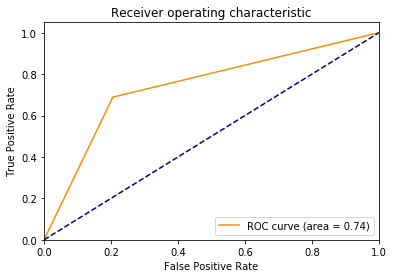

In [488]:
fpr, tpr, thresholds = metrics.roc_curve(y_train, y_train_pred)
roc_auc = metrics.auc(fpr,tpr)
plt.figure()
plt.plot(fpr, tpr, color='darkorange',  label='ROC curve (area = %0.2f)' % roc_auc)
plt.plot([0, 1], [0, 1], color='navy', linestyle='--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver operating characteristic')
plt.legend(loc="lower right")
plt.show()

In [ ]:
from sklearn.linear_model import LogisticRegression

In [ ]:
model_logreg = LogisticRegression()

In [491]:
model_logreg = model_logreg.fit(X_train_droped,y_train)
print("Training_score : ", model_logreg.score(X_train_droped,y_train))

Training_score :  0.9369306719793506


In [492]:
print("Test_score : ", model_logreg.score(X_test_droped,y_test))

Test_score :  0.9378523994486906


In [493]:
y_test_pred = model_logreg.predict(X_test_droped)
confusion_matrix(y_test, y_test_pred)

array([[37351,   112],
       [ 2368,    74]])

In [494]:
y_test_pred = model_logreg.predict(X_train_droped)
confusion_matrix(y_train, y_train_pred)

array([[118927,  30751],
       [  3091,   6849]])

In [495]:
model_logreg = LogisticRegression(penalty='l2', max_iter=300)
model_logreg = model_logreg.fit(X_train_final,y_train)
print("Training_score : ", model_logreg.score(X_train_final,y_train))

Training_score :  0.9445112706586977


/usr/local/lib/python3.6/dist-packages/sklearn/linear_model/_logistic.py:940: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  extra_warning_msg=_LOGISTIC_SOLVER_CONVERGENCE_MSG)


In [496]:
print("Training_score : ", model_logreg.score(X_test_final,y_test))

Training_score :  0.9448941235434156


In [497]:
y_test_pred = model_logreg.predict(X_test_final)
confusion_matrix(y_test, y_test_pred)

array([[37136,   327],
       [ 1872,   570]])

In [498]:
model_logreg.coef_

array([[-1.25636116, -1.10479238, -0.41800008, -0.55797563, -0.95017096,
        -1.45513188, -0.98020213,  0.03324906, -0.07826137,  1.0102835 ,
        -0.53843749,  2.52964137, -0.44142031, -0.27671235,  1.41243125,
         2.94612493,  0.0805495 , -0.70909159,  0.07005137,  0.32659329,
         0.15309046, -0.17945565, -0.12052329, -1.39040196, -1.23033655,
         0.6477842 , -0.22555777, -0.09398215,  1.35351727,  0.47214619,
         0.13115083,  0.74982921,  0.04510068, -0.02616042, -0.04022056,
         0.12994598, -0.0494153 , -0.12699203,  0.05203398, -0.05899891]])

In [ ]:
X_train_final_2 = X_train_droped
X_test_final_2 = X_test_droped

In [500]:
X_train_final_2.head(3)

,_c0,_c2,_c3,_c30,_c36,_c38,_c39,_c40
111528,40,43,12,4,0,2,28,95
182461,34,4,34,1,0,2,44,95
35925,6,0,0,0,0,0,0,94


In [501]:
clf_tree_rid = clf_tree.fit(X_train_final_2,y_train)
print("Training_score : ", clf_tree_rid.score(X_train_final_2,y_train))

Training_score :  0.9451127065869764


In [502]:
print("Test_score : ", clf_tree.score(X_test_final_2,y_test))

Test_score :  0.944167397569227


Result is the same, so we leave only two numeric features with bigger variance._c39 and _c40.Each have variance over 20.

In [ ]:
X_train_final_3 = X_train_droped[['_c39','_c40']]
X_test_final_3 = X_test_droped[['_c39','_c40']]

In [504]:
X_train_final_3.head(5)

,_c39,_c40
111528,28,95
182461,44,95
35925,0,94
4789,0,94
67727,0,94


In [505]:
clf_tree_rid2 = clf_tree.fit(X_train_final_3,y_train)
print("Training_score : ", clf_tree_rid2.score(X_train_final_3,y_train))

Training_score :  0.9377263215928028


In [506]:
print("Test_score : ", clf_tree.score(X_test_final_3,y_test))

Test_score :  0.9388046610700413


In [507]:
clf_tree_rid2.feature_importances_

array([0.99258582, 0.00741418])

In [508]:
X_train_final.shape

(159618, 40)

As a conclustion among all models win SVM model by the ROC-AUC curve, other models have better accuracy, but because of the dataset is skewed and we have only 6% of the postive class and 94% negative. It is a good understandable result, that we need to use SVM in our case. Of course we can do over sampling - and undersamplig, but it can be danger because we can break balance of our class, I will not to risk to do that thing in our case.

In [ ]:
# more try k_means clustering
from sklearn.cluster import KMeans

In [ ]:
kmeans = KMeans(n_clusters=2, random_state=0,algorithm = 'full').fit(X_train_final)
y_kmeans_pred = kmeans.predict(X_train_final)

In [511]:
print("Training_score : ", kmeans.score(X_train_final,y_train))
print("Accuracy training_score : ", metrics.accuracy_score(y_kmeans_pred,y_train))

Training_score :  -121270444.89553465
Accuracy training_score :  0.575135636331742


In [512]:
y_test_pred_kmeans = kmeans.predict(X_test_final)
confusion_matrix(y_test, y_test_pred_kmeans)

array([[20770, 16693],
       [  151,  2291]])

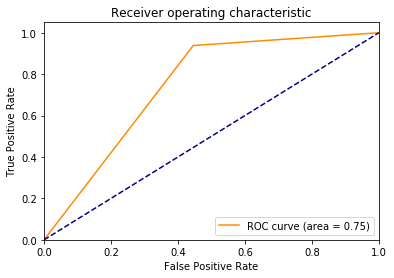

In [513]:
fpr, tpr, thresholds = metrics.roc_curve(y_test, y_test_pred_kmeans)
roc_auc = metrics.auc(fpr,tpr)
plt.figure()
plt.plot(fpr, tpr, color='darkorange',  label='ROC curve (area = %0.2f)' % roc_auc)
plt.plot([0, 1], [0, 1], color='navy', linestyle='--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver operating characteristic')
plt.legend(loc="lower right")
plt.show()

In [514]:
y_train_pred_kmeans = kmeans.predict(X_train_final)
confusion_matrix(y_train, y_train_pred_kmeans)

array([[82474, 67204],
       [  612,  9328]])

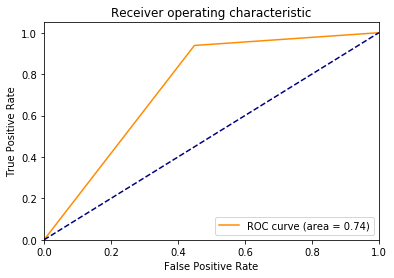

In [515]:
fpr, tpr, thresholds = metrics.roc_curve(y_train, y_train_pred_kmeans)
roc_auc = metrics.auc(fpr,tpr)
plt.figure()
plt.plot(fpr, tpr, color='darkorange',  label='ROC curve (area = %0.2f)' % roc_auc)
plt.plot([0, 1], [0, 1], color='navy', linestyle='--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver operating characteristic')
plt.legend(loc="lower right")
plt.show()

In [ ]:
#only numeric values.
kmeans = KMeans(n_clusters=2, random_state=0,algorithm = 'full').fit(X_train_droped)
y_kmeans_pred = kmeans.predict(X_test_droped)

In [517]:
print("Training_score : ", kmeans.score(X_train_droped,y_train))

Training_score :  -121069279.90257744


In [518]:
y_test_pred_kmeans2 = kmeans.predict(X_test_droped)
confusion_matrix(y_test, y_test_pred_kmeans2)

array([[16690, 20773],
       [ 2291,   151]])

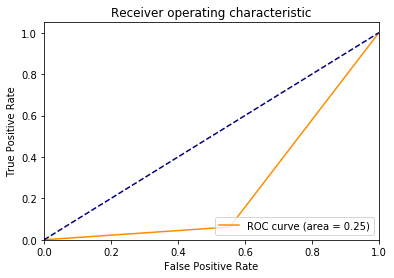

In [519]:
fpr, tpr, thresholds = metrics.roc_curve(y_test, y_test_pred_kmeans2)
roc_auc = metrics.auc(fpr,tpr)
plt.figure()
plt.plot(fpr, tpr, color='darkorange',  label='ROC curve (area = %0.2f)' % roc_auc)
plt.plot([0, 1], [0, 1], color='navy', linestyle='--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver operating characteristic')
plt.legend(loc="lower right")
plt.show()

In [520]:
y_train_pred_kmeans = kmeans.predict(X_train_droped)
confusion_matrix(y_train, y_train_pred_kmeans)

array([[67198, 82480],
       [ 9328,   612]])

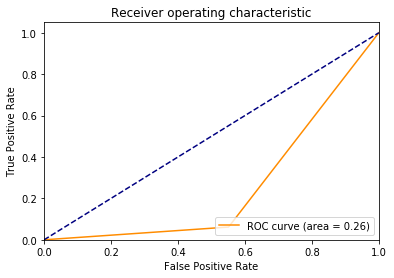

In [521]:
fpr, tpr, thresholds = metrics.roc_curve(y_train, y_train_pred_kmeans)
roc_auc = metrics.auc(fpr,tpr)
plt.figure()
plt.plot(fpr, tpr, color='darkorange',  label='ROC curve (area = %0.2f)' % roc_auc)
plt.plot([0, 1], [0, 1], color='navy', linestyle='--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver operating characteristic')
plt.legend(loc="lower right")
plt.show()

Here we clearly see that for SVM only our choosed numeric data is not enought and result is pretty bad. Ho to test our baseline - all reatures without any dropping.

In [ ]:
X_num_fet_train_df = X_train_copy[['_c0','_c2','_c3','_c5','_c16','_c17','_c18','_c24','_c30','_c36','_c38','_c39','_c40']]
X_num_fet_test_df = X_test_copy[['_c0','_c2','_c3','_c5','_c16','_c17','_c18','_c24','_c30','_c36','_c38','_c39','_c40']]

In [ ]:
kmeans = KMeans(n_clusters=2, random_state=0,algorithm = 'full').fit(X_num_fet_train_df)
y_kmeans_pred = kmeans.predict(X_num_fet_test_df)

In [524]:
print("Training_score : ", kmeans.score(X_num_fet_train_df,y_train))

Training_score :  -1223542957977.563


In [525]:
y_test_pred_kmeans2 = kmeans.predict(X_num_fet_test_df)
confusion_matrix(y_test, y_test_pred_kmeans2)

array([[37455,     8],
       [ 2365,    77]])

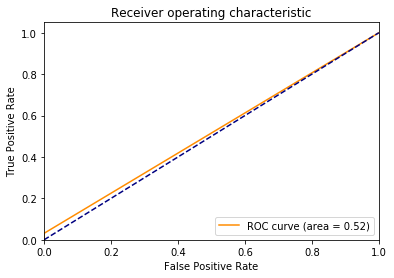

In [526]:
fpr, tpr, thresholds = metrics.roc_curve(y_test, y_test_pred_kmeans2)
roc_auc = metrics.auc(fpr,tpr)
plt.figure()
plt.plot(fpr, tpr, color='darkorange',  label='ROC curve (area = %0.2f)' % roc_auc)
plt.plot([0, 1], [0, 1], color='navy', linestyle='--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver operating characteristic')
plt.legend(loc="lower right")
plt.show()

In [527]:
#try only one hot encoded features.
X_train_final.head(5)

,10th grade,11th grade,12th grade no diploma,1st 2nd 3rd or 4th grade,5th or 6th grade,7th and 8th grade,9th grade,Associates degree-academic program,Associates degree-occup /vocational,Bachelors degree(BA AB BS),Children,Doctorate degree(PhD EdD),High school graduate,Less than 1st grade,Masters degree(MA MS MEng MEd MSW MBA),Prof school degree (MD DDS DVM LLB JD),Some college but no degree,Adm support including clerical,Armed Forces,Executive admin and managerial,Farming forestry and fishing,Handlers equip cleaners etc,Machine operators assmblrs & inspctrs,Not in universe,Other service,Precision production craft & repair,Private household services,Professional specialty,Protective services,Sales,Technicians and related support,Transportation and material moving,_c0,_c2,_c3,_c30,_c36,_c38,_c39,_c40
111528,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,40,43,12,4,0,2,28,95
182461,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,34,4,34,1,0,2,44,95
35925,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,6,0,0,0,0,0,0,94
4789,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,78,0,0,0,0,2,0,94
67727,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,9,0,0,0,0,0,0,94


In [ ]:
X_train_nonnim = X_train_final.drop(['_c0','_c2','_c3','_c30','_c36','_c38','_c40'],1)
X_test_nonnim = X_test_final.drop(['_c0','_c2','_c3','_c30','_c36','_c38','_c40'],1)
#we leave _39 - and it is make model great.

In [529]:
kmeans = KMeans(n_clusters=2, random_state=0).fit(X_train_nonnim)
y_kmeans_pred = kmeans.predict(X_train_nonnim)
print("Training_score : ", kmeans.score(X_train_nonnim,y_train))

Training_score :  -5159827.2159683425


In [530]:
#y_test_pred_kmeans2 = kmeans.predict(X_test_nonnim)
confusion_matrix(y_train, y_kmeans_pred)

array([[86441, 63237],
       [  622,  9318]])

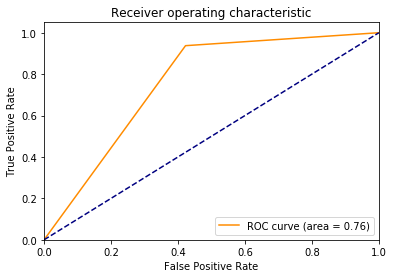

In [531]:
fpr, tpr, thresholds = metrics.roc_curve(y_train, y_kmeans_pred)
roc_auc = metrics.auc(fpr,tpr)
plt.figure()
plt.plot(fpr, tpr, color='darkorange',  label='ROC curve (area = %0.2f)' % roc_auc)
plt.plot([0, 1], [0, 1], color='navy', linestyle='--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver operating characteristic')
plt.legend(loc="lower right")
plt.show()

In [532]:
y_test_pred_kmeans = kmeans.predict(X_test_nonnim)
confusion_matrix(y_test, y_test_pred_kmeans)

array([[21713, 15750],
       [  155,  2287]])

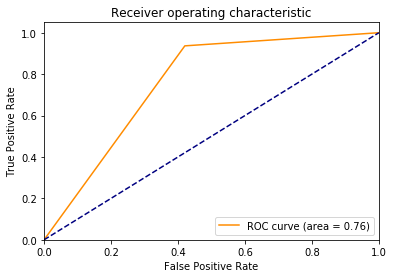

In [533]:
fpr, tpr, thresholds = metrics.roc_curve(y_test, y_test_pred_kmeans)
roc_auc = metrics.auc(fpr,tpr)
plt.figure()
plt.plot(fpr, tpr, color='darkorange',  label='ROC curve (area = %0.2f)' % roc_auc)
plt.plot([0, 1], [0, 1], color='navy', linestyle='--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver operating characteristic')
plt.legend(loc="lower right")
plt.show()

It shows us for the Kmens model more importantly in our case non numeric.We leave _c39 numeric feature and in gives us better rest. Now we try to make SVM model but only with one numeric feature _c39.


In [ ]:
#X_train_copy.head(5)
X_train_c39 = X_train_final_3.drop(['_c40'],1)
X_test_c39 = X_test_final_3.drop(['_c40'],1)

In [535]:
X_train_c39.head(3)

,_c39
111528,28
182461,44
35925,0


In [536]:
kmeans_c39 = KMeans(n_clusters=2, random_state=0).fit(X_train_c39)
y_train_pred_c39 = kmeans_c39.predict(X_train_c39)
print("Training_score : ", kmeans_c39.score(X_train_c39,y_train))
print("Accuracy training_score : ", metrics.accuracy_score(y_train_pred_c39,y_train))

Training_score :  -4952187.823719757
Accuracy training_score :  0.5999260735004824


In [537]:
#y_test_pred_3 = kmeans_3.predict(X_test_nonnim)
confusion_matrix(y_train, y_train_pred_c39)

array([[86441, 63237],
       [  622,  9318]])

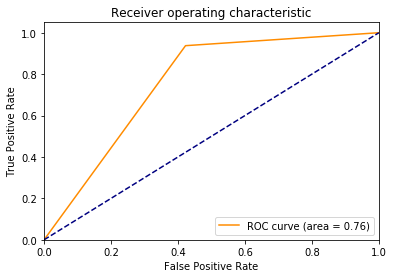

In [538]:
fpr, tpr, thresholds = metrics.roc_curve(y_train, y_train_pred_c39)
roc_auc = metrics.auc(fpr,tpr)
plt.figure()
plt.plot(fpr, tpr, color='darkorange',  label='ROC curve (area = %0.2f)' % roc_auc)
plt.plot([0, 1], [0, 1], color='navy', linestyle='--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver operating characteristic')
plt.legend(loc="lower right")
plt.show()

In [539]:
y_test_pred_c39 = kmeans_c39.predict(X_test_c39)
print("Test_score : ", kmeans_c39.score(X_test_c39,y_test))
print("Accuracy test_score : ", metrics.accuracy_score(y_test_pred_c39,y_test))

Test_score :  -1226860.587264178
Accuracy test_score :  0.6014283924320261


In [540]:
confusion_matrix(y_test, y_test_pred_c39)

array([[21713, 15750],
       [  155,  2287]])

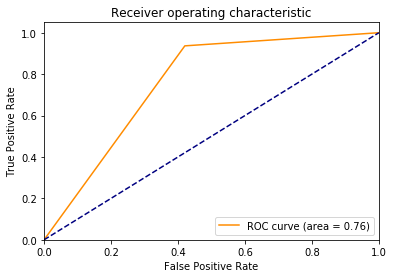

In [541]:
fpr, tpr, thresholds = metrics.roc_curve(y_test, y_test_pred_c39)
roc_auc = metrics.auc(fpr,tpr)
plt.figure()
plt.plot(fpr, tpr, color='darkorange',  label='ROC curve (area = %0.2f)' % roc_auc)
plt.plot([0, 1], [0, 1], color='navy', linestyle='--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver operating characteristic')
plt.legend(loc="lower right")
plt.show()

As a conclusion the best model for our dataset is K means and it can get us best predictions only by one numeric features, _c39.It is still not ideal because % rate is not ideal. Our best model is Kmeans clustering because the array of the ROC curve is the biggest one among many models. May be accuracy is not so great about 60%, it detect positive HighIncome cases more accurate then negatives cases. I think in this model correctly detected Highincome cases is more important for us.We can have 94% accuracy simly detect all cases as a Average income - False, but in that case ROC-AUC will be significant lower.
The most interesting part that KNN classier have not realised in Spark because KNN very hard to parallelise computation and KNN use one machine implementation. So we try to implement our next best model it is LogisticRegression model.

In next part we will use Spark ML algoritms and try it compare with Scikit learn algorirms and will work with Spark Dataframes instead of the Pandas dataframe.

### Part II

In [ ]:
from pyspark.ml.classification import LogisticRegression

In [543]:
data_df.show(5)

+---+--------------------+---+---+--------------------+---+----------------+--------------+--------------------+--------------------+--------------------+----------+-------+----------------+----------------+--------------------+----+----+----+------------------+----------------+----------------+--------------------+--------------------+--------+-----------+------------+------------+--------------------+----------------+----+--------------------+--------------+--------------+--------------+--------------------+----+----------------+----+----+----+---------+
|_c0|                 _c1|_c2|_c3|                 _c4|_c5|             _c6|           _c7|                 _c8|                 _c9|                _c10|      _c11|   _c12|            _c13|            _c14|                _c15|_c16|_c17|_c18|              _c19|            _c20|            _c21|                _c22|                _c23|    _c24|       _c25|        _c26|        _c27|                _c28|            _c29|_c30|         

Now we will work with spark data.

In [ ]:
numeric_features = ['_c0','_c2','_c3','_c5','_c16','_c17','_c18','_c30','_c36','_c38','_c39','_c40']
#all int _24 double
data_df_spark = data_df

In [ ]:
from pyspark.sql.types import DoubleType,IntegerType
for elem in numeric_features:
  data_df_spark = data_df_spark.withColumn(elem,data_df_spark[elem].cast("double").cast("integer"))
data_df_spark = data_df_spark.withColumn("_c24", data_df_spark['_c24'].cast("double"))


In [546]:
#data_df_spark.show(5)
data_df_spark.printSchema()

root
 |-- _c0: integer (nullable = true)
 |-- _c1: string (nullable = true)
 |-- _c2: integer (nullable = true)
 |-- _c3: integer (nullable = true)
 |-- _c4: string (nullable = true)
 |-- _c5: integer (nullable = true)
 |-- _c6: string (nullable = true)
 |-- _c7: string (nullable = true)
 |-- _c8: string (nullable = true)
 |-- _c9: string (nullable = true)
 |-- _c10: string (nullable = true)
 |-- _c11: string (nullable = true)
 |-- _c12: string (nullable = true)
 |-- _c13: string (nullable = true)
 |-- _c14: string (nullable = true)
 |-- _c15: string (nullable = true)
 |-- _c16: integer (nullable = true)
 |-- _c17: integer (nullable = true)
 |-- _c18: integer (nullable = true)
 |-- _c19: string (nullable = true)
 |-- _c20: string (nullable = true)
 |-- _c21: string (nullable = true)
 |-- _c22: string (nullable = true)
 |-- _c23: string (nullable = true)
 |-- _c24: double (nullable = true)
 |-- _c25: string (nullable = true)
 |-- _c26: string (nullable = true)
 |-- _c27: string (nullabl

In [ ]:
columns = data_df_spark.columns
#columns
from pyspark.sql.functions import when

In [ ]:
for elem in columns:
  data_df_spark = data_df_spark.withColumn(elem, when(data_df_spark[elem]==' ?',np.nan).otherwise(data_df_spark[elem]))

In [549]:
data_df_spark.show(20)

+----+--------------------+----+----+--------------------+------+----------------+--------------------+--------------------+--------------------+--------------------+--------------------+-------+----------------+--------------------+--------------------+------+------+------+--------------------+----------------+----------------+--------------------+--------------------+-------+-----------+------------+------------+--------------------+----------------+----+--------------------+--------------+--------------+--------------+--------------------+----+----------------+----+----+----+---------+
| _c0|                 _c1| _c2| _c3|                 _c4|   _c5|             _c6|                 _c7|                 _c8|                 _c9|                _c10|                _c11|   _c12|            _c13|                _c14|                _c15|  _c16|  _c17|  _c18|                _c19|            _c20|            _c21|                _c22|                _c23|   _c24|       _c25|        _c26

In [550]:
from pyspark.ml.feature import Imputer
numeric_features = ['_c0','_c2','_c3','_c5','_c16','_c17','_c18','_c24','_c30','_c36','_c38','_c39','_c40']
numeric_df = data_df_spark[numeric_features]
imputer = Imputer(inputCols= numeric_features, outputCols= numeric_features)
model = imputer.fit(numeric_df)
numeric_df = model.transform(numeric_df)
numeric_df.show(5)

+----+---+----+---+----+----+----+-------+----+----+----+----+----+
| _c0|_c2| _c3|_c5|_c16|_c17|_c18|   _c24|_c30|_c36|_c38|_c39|_c40|
+----+---+----+---+----+----+----+-------+----+----+----+----+----+
|73.0|0.0| 0.0|0.0| 0.0| 0.0| 0.0|1700.09| 0.0| 0.0| 2.0| 0.0|95.0|
|58.0|4.0|34.0|0.0| 0.0| 0.0| 0.0|1053.55| 1.0| 0.0| 2.0|52.0|94.0|
|18.0|0.0| 0.0|0.0| 0.0| 0.0| 0.0| 991.95| 0.0| 0.0| 2.0| 0.0|95.0|
| 9.0|0.0| 0.0|0.0| 0.0| 0.0| 0.0|1758.14| 0.0| 0.0| 0.0| 0.0|94.0|
|10.0|0.0| 0.0|0.0| 0.0| 0.0| 0.0|1069.16| 0.0| 0.0| 0.0| 0.0|94.0|
+----+---+----+---+----+----+----+-------+----+----+----+----+----+
only showing top 5 rows



In [ ]:
#data_df_spark_drop = data_df_spark.drop(['_c11','_c13','_c14','_c15','_c20','_c21','_c29','_c25','_c26','_c27','_c32','_c33','_c34'],1)
data_df_spark_drop = data_df_spark
droped_col = ['_c11','_c13','_c14','_c15','_c20','_c21','_c29','_c25','_c26','_c27','_c32','_c33','_c34']


In [ ]:
for elem in droped_col:
  data_df_spark_drop = data_df_spark_drop.drop(elem)

In [553]:
new_columns = data_df_spark_drop.columns
data_df_spark_drop.show(5)

+----+--------------------+---+----+--------------------+---+----------------+--------------+--------------------+--------------------+--------------------+-------+----+----+----+------------------+--------------------+--------------------+-------+--------------------+----+--------------------+--------------------+----+----------------+----+----+----+---------+
| _c0|                 _c1|_c2| _c3|                 _c4|_c5|             _c6|           _c7|                 _c8|                 _c9|                _c10|   _c12|_c16|_c17|_c18|              _c19|                _c22|                _c23|   _c24|                _c28|_c30|                _c31|                _c35|_c36|            _c37|_c38|_c39|_c40|     _c41|
+----+--------------------+---+----+--------------------+---+----------------+--------------+--------------------+--------------------+--------------------+-------+----+----+----+------------------+--------------------+--------------------+-------+--------------------+---

In [ ]:
from pyspark.sql import functions as f
data_df_spark_drop = data_df_spark_drop.withColumn('label', when(f.col('_c41') == ' - 50000.',0).otherwise(1.0))

In [ ]:
df_for_model = data_df_spark_drop['_c0','_c2','_c3','_c5','_c16','_c17','_c18','_c24','_c30','_c36','_c38','_c39','_c40','label']

In [556]:
df_for_model.show(10)

+----+----+----+------+------+----+----+-------+----+----+----+----+----+-----+
| _c0| _c2| _c3|   _c5|  _c16|_c17|_c18|   _c24|_c30|_c36|_c38|_c39|_c40|label|
+----+----+----+------+------+----+----+-------+----+----+----+----+----+-----+
|73.0| 0.0| 0.0|   0.0|   0.0| 0.0| 0.0|1700.09| 0.0| 0.0| 2.0| 0.0|95.0|  0.0|
|58.0| 4.0|34.0|   0.0|   0.0| 0.0| 0.0|1053.55| 1.0| 0.0| 2.0|52.0|94.0|  0.0|
|18.0| 0.0| 0.0|   0.0|   0.0| 0.0| 0.0| 991.95| 0.0| 0.0| 2.0| 0.0|95.0|  0.0|
| 9.0| 0.0| 0.0|   0.0|   0.0| 0.0| 0.0|1758.14| 0.0| 0.0| 0.0| 0.0|94.0|  0.0|
|10.0| 0.0| 0.0|   0.0|   0.0| 0.0| 0.0|1069.16| 0.0| 0.0| 0.0| 0.0|94.0|  0.0|
|48.0|40.0|10.0|1200.0|   0.0| 0.0| 0.0| 162.61| 1.0| 2.0| 2.0|52.0|95.0|  0.0|
|42.0|34.0| 3.0|   0.0|5178.0| 0.0| 0.0|1535.86| 6.0| 0.0| 2.0|52.0|94.0|  0.0|
|28.0| 4.0|40.0|   0.0|   0.0| 0.0| 0.0| 898.83| 4.0| 0.0| 2.0|30.0|95.0|  0.0|
|47.0|43.0|26.0| 876.0|   0.0| 0.0| 0.0|1661.53| 5.0| 0.0| 2.0|52.0|95.0|  0.0|
|34.0| 4.0|37.0|   0.0|   0.0| 0.0| 0.0|

In [ ]:
train,test = df_for_model.randomSplit([0.7,0.3],seed = 202)

In [ ]:
import pyspark.sql.functions as F
train = train.orderBy(F.rand())
test = test.orderBy(F.rand())

In [ ]:
feature_cols = ['_c0','_c2','_c3','_c5','_c16','_c17','_c18','_c24','_c30','_c36','_c38','_c39','_c40']
label_col = 'label'

In [ ]:
#make a feature vector
vectors_col = df_for_model.columns
vectors_col.remove('label')

In [ ]:
from pyspark.ml.feature import VectorAssembler

In [ ]:
assembler = VectorAssembler(inputCols=vectors_col,outputCol="features")
df_for_model=assembler.transform(df_for_model)

In [563]:
df_for_model.show(5)

+----+---+----+---+----+----+----+-------+----+----+----+----+----+-----+--------------------+
| _c0|_c2| _c3|_c5|_c16|_c17|_c18|   _c24|_c30|_c36|_c38|_c39|_c40|label|            features|
+----+---+----+---+----+----+----+-------+----+----+----+----+----+-----+--------------------+
|73.0|0.0| 0.0|0.0| 0.0| 0.0| 0.0|1700.09| 0.0| 0.0| 2.0| 0.0|95.0|  0.0|(13,[0,7,10,12],[...|
|58.0|4.0|34.0|0.0| 0.0| 0.0| 0.0|1053.55| 1.0| 0.0| 2.0|52.0|94.0|  0.0|[58.0,4.0,34.0,0....|
|18.0|0.0| 0.0|0.0| 0.0| 0.0| 0.0| 991.95| 0.0| 0.0| 2.0| 0.0|95.0|  0.0|(13,[0,7,10,12],[...|
| 9.0|0.0| 0.0|0.0| 0.0| 0.0| 0.0|1758.14| 0.0| 0.0| 0.0| 0.0|94.0|  0.0|(13,[0,7,12],[9.0...|
|10.0|0.0| 0.0|0.0| 0.0| 0.0| 0.0|1069.16| 0.0| 0.0| 0.0| 0.0|94.0|  0.0|(13,[0,7,12],[10....|
+----+---+----+---+----+----+----+-------+----+----+----+----+----+-----+--------------------+
only showing top 5 rows



In [564]:
from pyspark.ml.feature import StandardScaler
standardscaler=StandardScaler().setInputCol("features").setOutputCol("Scaled_features")
df_for_model=standardscaler.fit(df_for_model).transform(df_for_model)
df_for_model.select("features","Scaled_features").show(5)

+--------------------+--------------------+
|            features|     Scaled_features|
+--------------------+--------------------+
|(13,[0,7,10,12],[...|(13,[0,7,10,12],[...|
|[58.0,4.0,34.0,0....|[2.59962675019476...|
|(13,[0,7,10,12],[...|(13,[0,7,10,12],[...|
|(13,[0,7,12],[9.0...|(13,[0,7,12],[0.4...|
|(13,[0,7,12],[10....|(13,[0,7,12],[0.4...|
+--------------------+--------------------+
only showing top 5 rows



In [ ]:
train, test = df_for_model.randomSplit([0.8, 0.2], seed=12345)

In [ ]:
#check the balancing of our dataset
dataset_size=float(train.select("label").count())
numHighIncome=train.select("label").where('label == 1').count()

In [567]:
#We do this in pandas variant but for the whole dataset, now will do for train
per_ones=(float(numHighIncome)/float(dataset_size))*100
awerageIncome=float(dataset_size-numHighIncome)
print('The number of ones are {}'.format(numHighIncome))
print('Percentage of ones are {}'.format(per_ones))

The number of ones are 9939
Percentage of ones are 6.238818899120576


We have same % of the HighIncome persons it is 6% same as we count in Pandas dataframe variant. Our data extremelly unbalancing.

In [568]:
BalancingRatio= awerageIncome/dataset_size
print('BalancingRatio = {}'.format(BalancingRatio))

BalancingRatio = 0.9376118110087942


In [569]:
train=train.withColumn("classWeights", when(train.label == 1,BalancingRatio).otherwise(1-BalancingRatio))
train.select("classWeights").show(5)

+--------------------+
|        classWeights|
+--------------------+
|0.062388188991205795|
|0.062388188991205795|
|0.062388188991205795|
|0.062388188991205795|
|0.062388188991205795|
+--------------------+
only showing top 5 rows



In [570]:
train.describe().select('label').show()

+-------------------+
|              label|
+-------------------+
|             159309|
|0.06238818899120577|
|0.24186002160977774|
|                0.0|
|                1.0|
+-------------------+



In [571]:
from pyspark.ml.classification import LogisticRegression
lr = LogisticRegression(labelCol="label", featuresCol="Scaled_features",weightCol="classWeights",maxIter=10)
model=lr.fit(train)
predict_train=model.transform(train)
predict_test=model.transform(test)
predict_test.select("label","prediction").show(10)

+-----+----------+
|label|prediction|
+-----+----------+
|  0.0|       0.0|
|  0.0|       0.0|
|  0.0|       0.0|
|  0.0|       0.0|
|  0.0|       0.0|
|  0.0|       0.0|
|  0.0|       0.0|
|  0.0|       0.0|
|  0.0|       0.0|
|  0.0|       0.0|
+-----+----------+
only showing top 10 rows



In [572]:
predict_test.describe().select('prediction').show()

+-------------------+
|         prediction|
+-------------------+
|              40214|
|0.36972198736758344|
| 0.4827353666948841|
|                0.0|
|                1.0|
+-------------------+



In [ ]:
from pyspark.ml.evaluation import BinaryClassificationEvaluator
evaluator=BinaryClassificationEvaluator(rawPredictionCol="rawPrediction",labelCol="label")


In [574]:
predict_test.select("label","prediction","rawPrediction","probability").show(5)

+-----+----------+--------------------+--------------------+
|label|prediction|       rawPrediction|         probability|
+-----+----------+--------------------+--------------------+
|  0.0|       0.0|[4.99861933999315...|[0.99329796411542...|
|  0.0|       0.0|[4.99641317021125...|[0.99328326138653...|
|  0.0|       0.0|[4.99623050595378...|[0.99328204260946...|
|  0.0|       0.0|[5.04883329979390...|[0.99362409741031...|
|  0.0|       0.0|[5.04881065863593...|[0.99362395397130...|
+-----+----------+--------------------+--------------------+
only showing top 5 rows



In [575]:
print("The area under ROC for train set is {}".format(evaluator.evaluate(predict_train)))
print("The area under ROC for test set is {}".format(evaluator.evaluate(predict_test)))

The area under ROC for train set is 0.8360509996700705
The area under ROC for test set is 0.8402212688041863


For the Spark machine learnong models Logistic regression gives us better result +8% impouvment. Scikit learn gives us 76% and this models give us 84% of the ROC curve.

In [576]:
auroc = evaluator.evaluate(predict_test, {evaluator.metricName: "areaUnderROC"})
auprc = evaluator.evaluate(predict_test, {evaluator.metricName: "areaUnderPR"})
print("Area under ROC Curve: {:.4f}".format(auroc))
print("Area under PR Curve: {:.4f}".format(auprc))

Area under ROC Curve: 0.8402
Area under PR Curve: 0.2676


In [ ]:
trainingSummary = model.summary

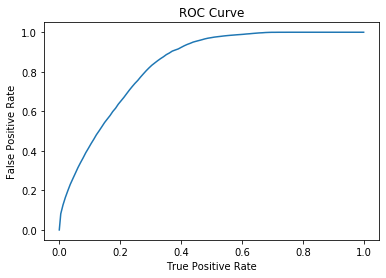

Training set areaUnderROC: 0.8359275233608012


In [578]:
roc = trainingSummary.roc.toPandas()
plt.plot(roc['FPR'],roc['TPR'])
plt.ylabel('False Positive Rate')
plt.xlabel('True Positive Rate')
plt.title('ROC Curve')
plt.show()
print('Training set areaUnderROC: ' + str(trainingSummary.areaUnderROC))

Print precision and recall

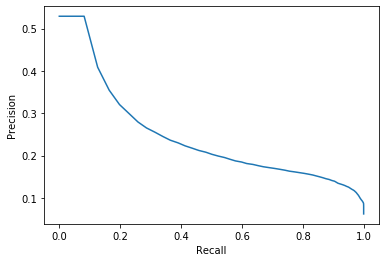

In [579]:
pr = trainingSummary.pr.toPandas()
plt.plot(pr['recall'],pr['precision'])
plt.ylabel('Precision')
plt.xlabel('Recall')
plt.show()

In [580]:
#Try decision tree classifier.
from pyspark.ml.classification import DecisionTreeClassifier
dt = DecisionTreeClassifier(featuresCol = "Scaled_features", labelCol = 'label', maxDepth = 3)
dtModel = dt.fit(train)
predictions = dtModel.transform(test)
predictions.select('label', 'rawPrediction', 'prediction', 'probability').show(10)

+-----+-----------------+----------+--------------------+
|label|    rawPrediction|prediction|         probability|
+-----+-----------------+----------+--------------------+
|  0.0|[149370.0,9939.0]|       0.0|[0.93761181100879...|
|  0.0|[149370.0,9939.0]|       0.0|[0.93761181100879...|
|  0.0|[149370.0,9939.0]|       0.0|[0.93761181100879...|
|  0.0|[149370.0,9939.0]|       0.0|[0.93761181100879...|
|  0.0|[149370.0,9939.0]|       0.0|[0.93761181100879...|
|  0.0|[149370.0,9939.0]|       0.0|[0.93761181100879...|
|  0.0|[149370.0,9939.0]|       0.0|[0.93761181100879...|
|  0.0|[149370.0,9939.0]|       0.0|[0.93761181100879...|
|  0.0|[149370.0,9939.0]|       0.0|[0.93761181100879...|
|  0.0|[149370.0,9939.0]|       0.0|[0.93761181100879...|
+-----+-----------------+----------+--------------------+
only showing top 10 rows



In [581]:
evaluator = BinaryClassificationEvaluator()
#trainingSummary = dt.summary
print("Test Area Under ROC: " + str(evaluator.evaluate(predictions, {evaluator.metricName: "areaUnderROC"})))

Test Area Under ROC: 0.5


In [582]:
from pyspark.ml.classification import RandomForestClassifier
rf = RandomForestClassifier(featuresCol = "Scaled_features", labelCol = 'label')
rfModel = rf.fit(train)
predictions = rfModel.transform(test)
predictions.select('label', 'rawPrediction', 'prediction', 'probability').show(10)

+-----+--------------------+----------+--------------------+
|label|       rawPrediction|prediction|         probability|
+-----+--------------------+----------+--------------------+
|  0.0|[19.7340901000836...|       0.0|[0.98670450500418...|
|  0.0|[19.7340901000836...|       0.0|[0.98670450500418...|
|  0.0|[19.7340901000836...|       0.0|[0.98670450500418...|
|  0.0|[19.7340901000836...|       0.0|[0.98670450500418...|
|  0.0|[19.7340901000836...|       0.0|[0.98670450500418...|
|  0.0|[19.7340901000836...|       0.0|[0.98670450500418...|
|  0.0|[19.7340901000836...|       0.0|[0.98670450500418...|
|  0.0|[19.7340901000836...|       0.0|[0.98670450500418...|
|  0.0|[19.7340901000836...|       0.0|[0.98670450500418...|
|  0.0|[19.7340901000836...|       0.0|[0.98670450500418...|
+-----+--------------------+----------+--------------------+
only showing top 10 rows



In [583]:
evaluator = BinaryClassificationEvaluator()
print("Test Area Under ROC: " + str(evaluator.evaluate(predictions, {evaluator.metricName: "areaUnderROC"})))

Test Area Under ROC: 0.9119459186109523


In [ ]:
#gradient busting classifier

In [ ]:
from pyspark.ml.classification import GBTClassifier

In [688]:
gbt = GBTClassifier(maxIter=10)
gbtModel = gbt.fit(train)
predictions = gbtModel.transform(test)
predictions.select('label', 'rawPrediction', 'prediction', 'probability').show(10)

+-----+--------------------+----------+--------------------+
|label|       rawPrediction|prediction|         probability|
+-----+--------------------+----------+--------------------+
|  0.0|[1.32471923714768...|       0.0|[0.93397637273940...|
|  0.0|[1.32471923714768...|       0.0|[0.93397637273940...|
|  0.0|[1.32471923714768...|       0.0|[0.93397637273940...|
|  0.0|[1.32471923714768...|       0.0|[0.93397637273940...|
|  0.0|[1.32471923714768...|       0.0|[0.93397637273940...|
|  0.0|[1.32471923714768...|       0.0|[0.93397637273940...|
|  0.0|[1.32471923714768...|       0.0|[0.93397637273940...|
|  0.0|[1.32471923714768...|       0.0|[0.93397637273940...|
|  0.0|[1.32471923714768...|       0.0|[0.93397637273940...|
|  0.0|[1.32471923714768...|       0.0|[0.93397637273940...|
+-----+--------------------+----------+--------------------+
only showing top 10 rows



In [587]:
evaluator = BinaryClassificationEvaluator()
predictions_train = gbtModel.transform(train)
print("Test Area Under ROC: " + str(evaluator.evaluate(predictions, {evaluator.metricName: "areaUnderROC"})))
print("Train Area Under ROC: " + str(evaluator.evaluate(predictions_train, {evaluator.metricName: "areaUnderROC"})))

Test Area Under ROC: 0.9249781898157768
Train Area Under ROC: 0.9215326115669649


In [ ]:
#To inprouve model we will use ParamGridBuilder and CrossValidator.
from pyspark.ml.tuning import ParamGridBuilder, CrossValidator

In [ ]:
paramGrid = (ParamGridBuilder()
             .addGrid(gbt.maxDepth, [2, 4, 6])
             .addGrid(gbt.maxBins, [20, 60])
             .addGrid(gbt.maxIter, [10, 20])
             .build())

In [ ]:
cv = CrossValidator(estimator=gbt, estimatorParamMaps=paramGrid, evaluator=evaluator, numFolds=5)

In [591]:
cvModel = cv.fit(train)
predictions = cvModel.transform(test)
evaluator.evaluate(predictions)

0.9351061066640984

In [689]:
confusion_matrix(test.select('label').toPandas(),predictions.select('prediction').toPandas())

array([[37536,   235],
       [ 1794,   649]])

Gradient busting gives us great result and Cross validation ang Pram Grid search gives us more improuvment.

In [ ]:
#One more test we will use GBTClassifier and one parameter._c39

In [ ]:
c30_df = df_for_model.select('_c39','_c3','label')

In [594]:
c30_df.show(5)

+----+----+-----+
|_c39| _c3|label|
+----+----+-----+
| 0.0| 0.0|  0.0|
|52.0|34.0|  0.0|
| 0.0| 0.0|  0.0|
| 0.0| 0.0|  0.0|
| 0.0| 0.0|  0.0|
+----+----+-----+
only showing top 5 rows



In [ ]:
#make a feature vector
vectors_col_c39 = c30_df.columns
vectors_col_c39.remove('label')

In [ ]:
assembler = VectorAssembler(inputCols=vectors_col_c39,outputCol="features")
c30_df=assembler.transform(c30_df)

In [597]:
standardscaler=StandardScaler().setInputCol("features").setOutputCol("Scaled_features")
c30_df=standardscaler.fit(c30_df).transform(c30_df)
c30_df.select("features","Scaled_features").show(5)

+-----------+--------------------+
|   features|     Scaled_features|
+-----------+--------------------+
|  (2,[],[])|           (2,[],[])|
|[52.0,34.0]|[2.13014461237232...|
|  (2,[],[])|           (2,[],[])|
|  (2,[],[])|           (2,[],[])|
|  (2,[],[])|           (2,[],[])|
+-----------+--------------------+
only showing top 5 rows



In [ ]:
train_c39,test_c39 = c30_df.randomSplit([0.7,0.3],seed = 2020)

In [599]:
gbt_39 = GBTClassifier(maxIter=10)
gbtModel_c39 = gbt.fit(train_c39)
predictions_c39 = gbtModel_c39.transform(test_c39)
predictions_c39.select('label', 'rawPrediction', 'prediction', 'probability').show(10)

+-----+--------------------+----------+--------------------+
|label|       rawPrediction|prediction|         probability|
+-----+--------------------+----------+--------------------+
|  0.0|[1.30102877501093...|       0.0|[0.93099388274062...|
|  0.0|[1.30102877501093...|       0.0|[0.93099388274062...|
|  0.0|[1.30102877501093...|       0.0|[0.93099388274062...|
|  0.0|[1.30102877501093...|       0.0|[0.93099388274062...|
|  0.0|[1.30102877501093...|       0.0|[0.93099388274062...|
|  0.0|[1.30102877501093...|       0.0|[0.93099388274062...|
|  0.0|[1.30102877501093...|       0.0|[0.93099388274062...|
|  0.0|[1.30102877501093...|       0.0|[0.93099388274062...|
|  0.0|[1.30102877501093...|       0.0|[0.93099388274062...|
|  0.0|[1.30102877501093...|       0.0|[0.93099388274062...|
+-----+--------------------+----------+--------------------+
only showing top 10 rows



In [600]:
evaluator = BinaryClassificationEvaluator()
predictions_train_c39 = gbtModel.transform(train_c39)
print("Test Area Under ROC: " + str(evaluator.evaluate(predictions_c39, {evaluator.metricName: "areaUnderROC"})))

Test Area Under ROC: 0.8793039843604676


In [686]:
confusion_matrix(test_c39.select('label').toPandas(),predictions_c39.select('prediction').toPandas())

array([[55906,    51],
       [ 3572,   136]])

As final decision we need use Gradient-Boosted Tree Classifier for the saving space we can use only two parameters _c3 and _c39 it gives us great performace.We need to use MLLib because it is fast and gives better result to our dataset. Only two parameters _c3 and _c39 gives us model with 0.88 ROC - our model with all numeric features gives us 0.93 ROC.According to confusion matrix this tho variables gives us compleet information about people with Awerage income, not contain information about HighIncome peoples. We correctly find all True-negative - Awerage income persons, but extremelly bad find HighIncome persons - Have too much False-Negative results.

## 12.	Explain the steps taken to avoid model overfitting.

We can prevent overfitting making the following steps. Use cross validation - we use it in our best model and it gives us +1% of ROC boosting. If possible we need to train on more data set - in our case we can make train/test split not 70-30 but 85-15 it gives us more data, but we not need to forget that our dataset is extremelly unbalanced.Also we can remove some not nesesssary features - like in our exmaple we train our model only on 2 numerical features instead of all 40 features, and we have a little dicrease our result. Also to prevent overfitting we can use ensemble methods - as we find in our case this type of algorithm gives us best result.

## 13.	What changes do you propose to make this modeling process more effective, if you are to train this in a cluster with 1,000 nodes, 300 million rows and 5,000 features in AWS?

First of all we need to choose most important features for our predictions. In our case from the 41 features from beginning we choose only two numeric features _c3,_c39 and it give us 0.87 ROC on the test set. Next we need to choose calculation method which are good parallelise for computation - not KNN as we find good in part with sci-kit learn. Next we need to use HDFS format for our data to speed up process of copy files.Also we can rewrite all this to the Scala API - it is faster then Python.Also we need to use MLLib instead of the SciKit learn because MLLib it make computation in memory and very fast.

In [ ]:
####One more attempt clearly Spark

### Part III

In [ ]:
data_df_2 = data_df

In [ ]:
data_df_2 = spark.read.csv('/content/census-income.csv',header = False, inferSchema = True)


In [604]:
data_df_2.printSchema()

root
 |-- _c0: integer (nullable = true)
 |-- _c1: string (nullable = true)
 |-- _c2: double (nullable = true)
 |-- _c3: double (nullable = true)
 |-- _c4: string (nullable = true)
 |-- _c5: double (nullable = true)
 |-- _c6: string (nullable = true)
 |-- _c7: string (nullable = true)
 |-- _c8: string (nullable = true)
 |-- _c9: string (nullable = true)
 |-- _c10: string (nullable = true)
 |-- _c11: string (nullable = true)
 |-- _c12: string (nullable = true)
 |-- _c13: string (nullable = true)
 |-- _c14: string (nullable = true)
 |-- _c15: string (nullable = true)
 |-- _c16: double (nullable = true)
 |-- _c17: double (nullable = true)
 |-- _c18: double (nullable = true)
 |-- _c19: string (nullable = true)
 |-- _c20: string (nullable = true)
 |-- _c21: string (nullable = true)
 |-- _c22: string (nullable = true)
 |-- _c23: string (nullable = true)
 |-- _c24: double (nullable = true)
 |-- _c25: string (nullable = true)
 |-- _c26: string (nullable = true)
 |-- _c27: string (nullable = tr

In [605]:
pd.DataFrame(data_df_2.take(2), columns=data_df_2.columns)

,_c0,_c1,_c2,_c3,_c4,_c5,_c6,_c7,_c8,_c9,_c10,_c11,_c12,_c13,_c14,_c15,_c16,_c17,_c18,_c19,_c20,_c21,_c22,_c23,_c24,_c25,_c26,_c27,_c28,_c29,_c30,_c31,_c32,_c33,_c34,_c35,_c36,_c37,_c38,_c39,_c40,_c41
0,73,Not in universe,0.0,0.0,High school graduate,0.0,Not in universe,Widowed,Not in universe or children,Not in universe,White,All other,Female,Not in universe,Not in universe,Not in labor force,0.0,0.0,0.0,Nonfiler,Not in universe,Not in universe,Other Rel 18+ ever marr not in subfamily,Other relative of householder,1700.09,?,?,?,Not in universe under 1 year old,?,0.0,Not in universe,United-States,United-States,United-States,Native- Born in the United States,0.0,Not in universe,2.0,0.0,95.0,- 50000.
1,58,Self-employed-not incorporated,4.0,34.0,Some college but no degree,0.0,Not in universe,Divorced,Construction,Precision production craft & repair,White,All other,Male,Not in universe,Not in universe,Children or Armed Forces,0.0,0.0,0.0,Head of household,South,Arkansas,Householder,Householder,1053.55,MSA to MSA,Same county,Same county,No,Yes,1.0,Not in universe,United-States,United-States,United-States,Native- Born in the United States,0.0,Not in universe,2.0,52.0,94.0,- 50000.


In [606]:
data_df_2 = data_df_2.withColumn("_c0", data_df_2['_c0'].cast("double"))

numeric_features_2 = [t[0] for t in data_df_2.dtypes if t[1]=='double']
data_df_2.select(numeric_features_2).describe().toPandas()

,summary,_c0,_c2,_c3,_c5,_c16,_c17,_c18,_c24,_c30,_c36,_c38,_c39,_c40
0,count,199523,199523,199523,199523,199523,199523,199523,199523,199523,199523,199523,199523,199523
1,mean,34.494198663813194,15.352320283877047,11.306556136385279,55.426908175999756,434.7189897906507,37.313788385298935,197.52953293605248,1740.3802692922914,1.9561804904697704,0.17543842063321022,1.5148328764102383,23.174897129654227,94.49967171704515
2,stddev,22.310895206650393,18.067128797857933,14.454203916353723,274.8964539028424,4697.531279712537,271.896428364965,1984.1636583823274,993.7681557874054,2.3651255054923626,0.5536943993004241,0.8514734448628327,24.411488167504192,0.5000011452231089
3,min,0.0,0.0,0.0,0.0,0.0,0.0,0.0,37.87,0.0,0.0,0.0,0.0,94.0
4,max,90.0,51.0,46.0,9999.0,99999.0,4608.0,99999.0,18656.3,6.0,2.0,2.0,52.0,95.0


In [ ]:
numeric_data = data_df_2.select(numeric_features_2).toPandas()

In [608]:
droped_col = ['_c11','_c13','_c14','_c15','_c20','_c21','_c29','_c25','_c26','_c27','_c32','_c33','_c34']
for elem in droped_col:
  data_df_spark_drop_2 = data_df_2.drop(elem)

cols = data_df_spark_drop_2.columns
data_df_spark_drop_2.printSchema()


root
 |-- _c0: double (nullable = true)
 |-- _c1: string (nullable = true)
 |-- _c2: double (nullable = true)
 |-- _c3: double (nullable = true)
 |-- _c4: string (nullable = true)
 |-- _c5: double (nullable = true)
 |-- _c6: string (nullable = true)
 |-- _c7: string (nullable = true)
 |-- _c8: string (nullable = true)
 |-- _c9: string (nullable = true)
 |-- _c10: string (nullable = true)
 |-- _c11: string (nullable = true)
 |-- _c12: string (nullable = true)
 |-- _c13: string (nullable = true)
 |-- _c14: string (nullable = true)
 |-- _c15: string (nullable = true)
 |-- _c16: double (nullable = true)
 |-- _c17: double (nullable = true)
 |-- _c18: double (nullable = true)
 |-- _c19: string (nullable = true)
 |-- _c20: string (nullable = true)
 |-- _c21: string (nullable = true)
 |-- _c22: string (nullable = true)
 |-- _c23: string (nullable = true)
 |-- _c24: double (nullable = true)
 |-- _c25: string (nullable = true)
 |-- _c26: string (nullable = true)
 |-- _c27: string (nullable = tru

In [ ]:
from pyspark.ml.feature import OneHotEncoderEstimator, StringIndexer, VectorAssembler

In [ ]:
nonNum_columns = ['_c1','_c4','_c6','_c7','_c8','_c9','_c10','_c12','_c19','_c22','_c23','_c28',
               '_c31','_c35','_c37']
stages = []
#We will not take as non numeric feature _c41 because it nave correlation 1 with target.

In [ ]:
for elem in nonNum_columns:
    stringIndexer = StringIndexer(inputCol = elem, outputCol = elem + 'Index')
    encoder = OneHotEncoderEstimator(inputCols=[stringIndexer.getOutputCol()], outputCols=[elem + "classVec"])
    stages += [stringIndexer, encoder]

In [ ]:
label_stringIdx = StringIndexer(inputCol = '_c41', outputCol = 'label')
stages += [label_stringIdx]

In [ ]:
numericCols = ['_c0','_c2','_c3','_c5','_c16','_c17','_c18','_c24','_c30','_c36','_c38','_c39','_c40']
assemblerInputs = [c + "classVec" for c in nonNum_columns] + numericCols
assembler = VectorAssembler(inputCols=assemblerInputs, outputCol="features")
stages += [assembler]

In [ ]:
from pyspark.ml import Pipeline

In [ ]:
pipeline = Pipeline(stages = stages)
pipelineModel = pipeline.fit(data_df_spark_drop_2)

In [ ]:
data_df_spark_drop_2 = pipelineModel.transform(data_df_spark_drop_2)
selectedCols = ['label', 'features'] + cols

In [617]:
data_df_spark_drop_2 = data_df_spark_drop_2.select(selectedCols)
data_df_spark_drop_2.printSchema()

root
 |-- label: double (nullable = false)
 |-- features: vector (nullable = true)
 |-- _c0: double (nullable = true)
 |-- _c1: string (nullable = true)
 |-- _c2: double (nullable = true)
 |-- _c3: double (nullable = true)
 |-- _c4: string (nullable = true)
 |-- _c5: double (nullable = true)
 |-- _c6: string (nullable = true)
 |-- _c7: string (nullable = true)
 |-- _c8: string (nullable = true)
 |-- _c9: string (nullable = true)
 |-- _c10: string (nullable = true)
 |-- _c11: string (nullable = true)
 |-- _c12: string (nullable = true)
 |-- _c13: string (nullable = true)
 |-- _c14: string (nullable = true)
 |-- _c15: string (nullable = true)
 |-- _c16: double (nullable = true)
 |-- _c17: double (nullable = true)
 |-- _c18: double (nullable = true)
 |-- _c19: string (nullable = true)
 |-- _c20: string (nullable = true)
 |-- _c21: string (nullable = true)
 |-- _c22: string (nullable = true)
 |-- _c23: string (nullable = true)
 |-- _c24: double (nullable = true)
 |-- _c25: string (nullable

In [618]:
pd.DataFrame(data_df_spark_drop_2.take(2), columns=data_df_spark_drop_2.columns)

,label,features,_c0,_c1,_c2,_c3,_c4,_c5,_c6,_c7,_c8,_c9,_c10,_c11,_c12,_c13,_c14,_c15,_c16,_c17,_c18,_c19,_c20,_c21,_c22,_c23,_c24,_c25,_c26,_c27,_c28,_c29,_c30,_c31,_c32,_c33,_c35,_c36,_c37,_c38,_c39,_c40,_c41
0,0.0,"(1.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 1.0, ...",73.0,Not in universe,0.0,0.0,High school graduate,0.0,Not in universe,Widowed,Not in universe or children,Not in universe,White,All other,Female,Not in universe,Not in universe,Not in labor force,0.0,0.0,0.0,Nonfiler,Not in universe,Not in universe,Other Rel 18+ ever marr not in subfamily,Other relative of householder,1700.09,?,?,?,Not in universe under 1 year old,?,0.0,Not in universe,United-States,United-States,Native- Born in the United States,0.0,Not in universe,2.0,0.0,95.0,- 50000.
1,0.0,"(0.0, 0.0, 1.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ...",58.0,Self-employed-not incorporated,4.0,34.0,Some college but no degree,0.0,Not in universe,Divorced,Construction,Precision production craft & repair,White,All other,Male,Not in universe,Not in universe,Children or Armed Forces,0.0,0.0,0.0,Head of household,South,Arkansas,Householder,Householder,1053.55,MSA to MSA,Same county,Same county,No,Yes,1.0,Not in universe,United-States,United-States,Native- Born in the United States,0.0,Not in universe,2.0,52.0,94.0,- 50000.


In [619]:
train_2, test_2 = data_df_spark_drop_2.randomSplit([0.7, 0.3], seed = 2018)
print("Training Dataset Count: " + str(train_2.count()))
print("Test Dataset Count: " + str(test_2.count()))

Training Dataset Count: 139417
Test Dataset Count: 60106


In [ ]:
import pyspark.sql.functions as F
train_2 = train_2.orderBy(F.rand())
test_2 = test_2.orderBy(F.rand())

In [ ]:
from pyspark.ml.classification import LogisticRegression
lr = LogisticRegression(featuresCol = 'features', labelCol = 'label', maxIter=10)
lrModel = lr.fit(train_2)

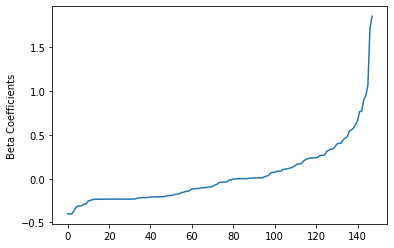

In [622]:
beta = np.sort(lrModel.coefficients)
plt.plot(beta)
plt.ylabel('Beta Coefficients')
plt.show()

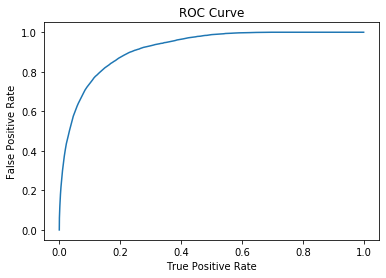

Training set areaUnderROC: 0.9185637247775889


In [623]:
trainingSummary = lrModel.summary
roc = trainingSummary.roc.toPandas()
plt.plot(roc['FPR'],roc['TPR'])
plt.ylabel('False Positive Rate')
plt.xlabel('True Positive Rate')
plt.title('ROC Curve')
plt.show()
print('Training set areaUnderROC: ' + str(trainingSummary.areaUnderROC))

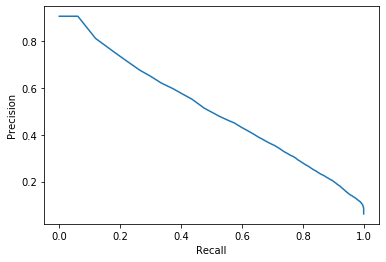

In [624]:
pr = trainingSummary.pr.toPandas()
plt.plot(pr['recall'],pr['precision'])
plt.ylabel('Precision')
plt.xlabel('Recall')
plt.show()

In [653]:
predictions = lrModel.transform(test_2)
predictions_tr = lrModel.transform(train_2)
predictions.select('label', 'rawPrediction', 'prediction', 'probability').show(10)

+-----+--------------------+----------+--------------------+
|label|       rawPrediction|prediction|         probability|
+-----+--------------------+----------+--------------------+
|  0.0|[1.03128429625678...|       0.0|[0.73716480768036...|
|  0.0|[2.13260444981955...|       0.0|[0.89403200405916...|
|  0.0|[3.50938060839531...|       0.0|[0.97095350068072...|
|  0.0|[4.50358252932001...|       0.0|[0.98905191783463...|
|  0.0|[6.03384764344569...|       0.0|[0.99760947203907...|
|  1.0|[1.96247414800637...|       0.0|[0.87680046264695...|
|  0.0|[6.03754515911211...|       0.0|[0.99761827371934...|
|  0.0|[9.40631043483829...|       0.0|[0.99991780307251...|
|  0.0|[3.4970126991069,...|       0.0|[0.97060265188596...|
|  0.0|[9.40009518110593...|       0.0|[0.99991729064923...|
+-----+--------------------+----------+--------------------+
only showing top 10 rows



In [663]:
confusion_matrix(test_2.select('label').toPandas(),predictions.select('prediction').toPandas())

array([[55890,   413],
       [ 2815,   988]])

In [664]:
confusion_matrix(train_2.select('label').toPandas(),predictions_tr.select('prediction').toPandas())

array([[129840,    998],
       [  6416,   2163]])

In [628]:
from pyspark.ml.evaluation import BinaryClassificationEvaluator
evaluator = BinaryClassificationEvaluator()
print('Test Area Under ROC', evaluator.evaluate(predictions))

Test Area Under ROC 0.9178767507756584


In [629]:
predictions_train = lrModel.transform(train_2)
evaluator = BinaryClassificationEvaluator()
print('Test Area Under ROC', evaluator.evaluate(predictions_train))

Test Area Under ROC 0.9185909391297412


In [ ]:
#Decision Tree Classifier

In [ ]:
from pyspark.ml.classification import DecisionTreeClassifier


In [665]:
dt = DecisionTreeClassifier(featuresCol = 'features', labelCol = 'label', maxDepth = 3)
dtModel = dt.fit(train_2)
predictions = dtModel.transform(test_2)
predictions_tr = dtModel.transform(train_2)
predictions.select('label', 'rawPrediction', 'prediction', 'probability').show(10)

+-----+-----------------+----------+--------------------+
|label|    rawPrediction|prediction|         probability|
+-----+-----------------+----------+--------------------+
|  0.0|[120880.0,5068.0]|       0.0|[0.95976117127703...|
|  0.0|[120880.0,5068.0]|       0.0|[0.95976117127703...|
|  0.0|[120880.0,5068.0]|       0.0|[0.95976117127703...|
|  0.0|[120880.0,5068.0]|       0.0|[0.95976117127703...|
|  0.0|   [4842.0,407.0]|       0.0|[0.92246142122309...|
|  1.0|[120880.0,5068.0]|       0.0|[0.95976117127703...|
|  0.0|[120880.0,5068.0]|       0.0|[0.95976117127703...|
|  0.0|[120880.0,5068.0]|       0.0|[0.95976117127703...|
|  0.0|[120880.0,5068.0]|       0.0|[0.95976117127703...|
|  0.0|[120880.0,5068.0]|       0.0|[0.95976117127703...|
+-----+-----------------+----------+--------------------+
only showing top 10 rows



In [633]:
evaluator = BinaryClassificationEvaluator()
print("Test Area Under ROC: " + str(evaluator.evaluate(predictions, {evaluator.metricName: "areaUnderROC"})))

Test Area Under ROC: 0.3463832125330998


In [666]:

confusion_matrix(test_2.select('label').toPandas(),predictions.select('prediction').toPandas())

array([[55261,  1042],
       [ 2719,  1084]])

In [667]:

evaluator = BinaryClassificationEvaluator()
print("Test Area Under ROC: " + str(evaluator.evaluate(predictions_tr, {evaluator.metricName: "areaUnderROC"})))

Test Area Under ROC: 0.3415610868679039


In [669]:
confusion_matrix(train_2.select('label').toPandas(),predictions_tr.select('prediction').toPandas())

array([[128467,   2371],
       [  6102,   2477]])

One simple decision tree performed poorly because it is too weak given the range of different features.

In [ ]:
#Random Forest Classifier

In [ ]:
from pyspark.ml.classification import RandomForestClassifier

In [670]:
rf = RandomForestClassifier(featuresCol = 'features', labelCol = 'label')
rfModel = rf.fit(train_2)
predictions = rfModel.transform(test_2)
predictions_tr = rfModel.transform(train_2)
predictions.select('label', 'rawPrediction', 'prediction', 'probability').show(10)

+-----+--------------------+----------+--------------------+
|label|       rawPrediction|prediction|         probability|
+-----+--------------------+----------+--------------------+
|  0.0|[17.8746249251447...|       0.0|[0.89373124625723...|
|  0.0|[17.9782835028756...|       0.0|[0.89891417514378...|
|  0.0|[18.4648459700592...|       0.0|[0.92324229850296...|
|  0.0|[18.7604788202766...|       0.0|[0.93802394101383...|
|  0.0|[18.8859616794261...|       0.0|[0.94429808397130...|
|  1.0|[18.2235891275536...|       0.0|[0.91117945637768...|
|  0.0|[19.1184109744780...|       0.0|[0.95592054872390...|
|  0.0|[19.7408234431447...|       0.0|[0.98704117215723...|
|  0.0|[18.7323860308279...|       0.0|[0.93661930154139...|
|  0.0|[19.7408234431447...|       0.0|[0.98704117215723...|
+-----+--------------------+----------+--------------------+
only showing top 10 rows



In [640]:
evaluator = BinaryClassificationEvaluator()
print("Test Area Under ROC: " + str(evaluator.evaluate(predictions, {evaluator.metricName: "areaUnderROC"})))

Test Area Under ROC: 0.9143078529743762


In [671]:
confusion_matrix(test_2.select('label').toPandas(),predictions.select('prediction').toPandas())

array([[56301,     2],
       [ 3779,    24]])

In [672]:

evaluator = BinaryClassificationEvaluator()
print("Test Area Under ROC: " + str(evaluator.evaluate(predictions_tr, {evaluator.metricName: "areaUnderROC"})))

Test Area Under ROC: 0.914774234262102


In [673]:
confusion_matrix(train_2.select('label').toPandas(),predictions_tr.select('prediction').toPandas())

array([[130837,      1],
       [  8534,     45]])

In [ ]:
#Gradient-Boosted Tree Classifier

In [ ]:
from pyspark.ml.classification import GBTClassifier

In [680]:
gbt = GBTClassifier(maxIter=10)
gbtModel = gbt.fit(train_2)
predictions = gbtModel.transform(test_2)
predictions_tr = gbtModel.transform(train_2)
predictions.select('label', 'rawPrediction', 'prediction', 'probability').show(10)

+-----+--------------------+----------+--------------------+
|label|       rawPrediction|prediction|         probability|
+-----+--------------------+----------+--------------------+
|  0.0|[1.05753794477065...|       0.0|[0.89235986329597...|
|  0.0|[1.12195615099049...|       0.0|[0.90412412766214...|
|  0.0|[1.26352384825077...|       0.0|[0.92601634508576...|
|  0.0|[1.25768175643486...|       0.0|[0.92521186553586...|
|  0.0|[1.09075716074406...|       0.0|[0.89857716499719...|
|  1.0|[1.12331825809480...|       0.0|[0.90436001276391...|
|  0.0|[1.31549625124250...|       0.0|[0.93282976474628...|
|  0.0|[1.31549625124250...|       0.0|[0.93282976474628...|
|  0.0|[1.11702068565380...|       0.0|[0.90326505905397...|
|  0.0|[1.31549625124250...|       0.0|[0.93282976474628...|
+-----+--------------------+----------+--------------------+
only showing top 10 rows



In [675]:
evaluator = BinaryClassificationEvaluator()
print("Test Area Under ROC: " + str(evaluator.evaluate(predictions, {evaluator.metricName: "areaUnderROC"})))

Test Area Under ROC: 0.9335604405465342


In [676]:
confusion_matrix(test_2.select('label').toPandas(),predictions.select('prediction').toPandas())

array([[55887,   416],
       [ 2732,  1071]])

In [677]:

evaluator = BinaryClassificationEvaluator()
print("Test Area Under ROC: " + str(evaluator.evaluate(predictions_tr, {evaluator.metricName: "areaUnderROC"})))

Test Area Under ROC: 0.9147742342621019


In [682]:
confusion_matrix(train_2.select('label').toPandas(),predictions_tr.select('prediction').toPandas())

array([[129957,    881],
       [  6242,   2337]])

Again in the case of the analyse whole dataset Gradient-Boosted Tree Classifier - gives us best result by ROC. With all features dataset we achieve ROC - 0.93 on the test set. In case with two numeric variables _c3,_c39 we acieve ROC - 0.87 is shows how we can save computation power and model comlexity.Price of that two features only too many False - Negative cases.Because our dataset is very unbalanced the result of predicting HighIncome quite complicated, we need more data or create may be a new feature for that. Thanks for that assignment.